In [1]:
#!conda env list

In [2]:
#!conda run -p /home/njm12/ATMS_523/envs/xarray-climate python -m ipykernel install --user --name xarray-climate --display-name "Python (xarray-climate)"

In [3]:
import sys
print(sys.executable)

/home/njm12/ATMS_523/envs/xarray-climate/bin/python


In [4]:
# Cell 1: Imports and environment setup
import os
import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point, box
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from shapely.ops import nearest_points

#Interactive Tool Imports
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"  # or "notebook_connected"

#Statistical Significance Testing Imports
from scipy.stats import kruskal, mannwhitneyu
import itertools

# Allow OGR to accept non-closed rings
os.environ["OGR_GEOMETRY_ACCEPT_UNCLOSED_RING"] = "YES"

# --- Configuration ---
base_dir = "/home/njm12/ATMS_596/Land-Water"
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_csv = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"  # Update with your CSV path
states_of_interest = ["IL", "IA", "MO"]
min_date = pd.to_datetime("1950-01-01")  # Start from first date in dataset 

In [5]:
# Cell 2: Load UMESC Mississippi River shapefiles
pool_dirs = [f"Pool {p}" for p in range(12, 27) if p != 23] + ["Open River", "Open River 2"]
gdfs = []

for pool_dir in pool_dirs:
    if "Open River" in pool_dir:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z16n83.shp"))
        local_crs = "EPSG:26916"
    else:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z15n83.shp"))
        local_crs = target_crs

    for f in shp_files:
        gdf = gpd.read_file(f)
        if gdf.crs is None:
            gdf = gdf.set_crs(local_crs)
        gdf = gdf.to_crs(target_crs)
        gdf["POOL"] = pool_dir
        gdfs.append(gdf)

umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)
print("UMESC combined:", umesc_all.shape)
print(f"Pools included: {sorted(umesc_all['POOL'].unique())}")

ERROR 1: PROJ: proj_create_from_database: Open of /home/njm12/ATMS_523/envs/xarray-climate/share/proj failed


UMESC combined: (8050, 14)
Pools included: ['Open River', 'Open River 2', 'Pool 12', 'Pool 13', 'Pool 14', 'Pool 15', 'Pool 16', 'Pool 17', 'Pool 18', 'Pool 19', 'Pool 20', 'Pool 21', 'Pool 22', 'Pool 24', 'Pool 25', 'Pool 26']


In [6]:
# --- Derive approximate river centerline from UMESC polygons ---
# Fix invalid polygons before union
umesc_all["geometry"] = umesc_all.geometry.make_valid()
umesc_all["geometry"] = umesc_all.buffer(0)  # Ensures clean geometry

# Use the new 'union_all()' method (replaces deprecated unary_union)
river_union = umesc_all.union_all()

# Derive approximate river centerline
river_centerline = gpd.GeoSeries([river_union], crs=target_crs).buffer(-200).boundary
river_centerline = gpd.GeoDataFrame(geometry=river_centerline, crs=target_crs)
print("River centerline constructed from UMESC polygons.")

River centerline constructed from UMESC polygons.


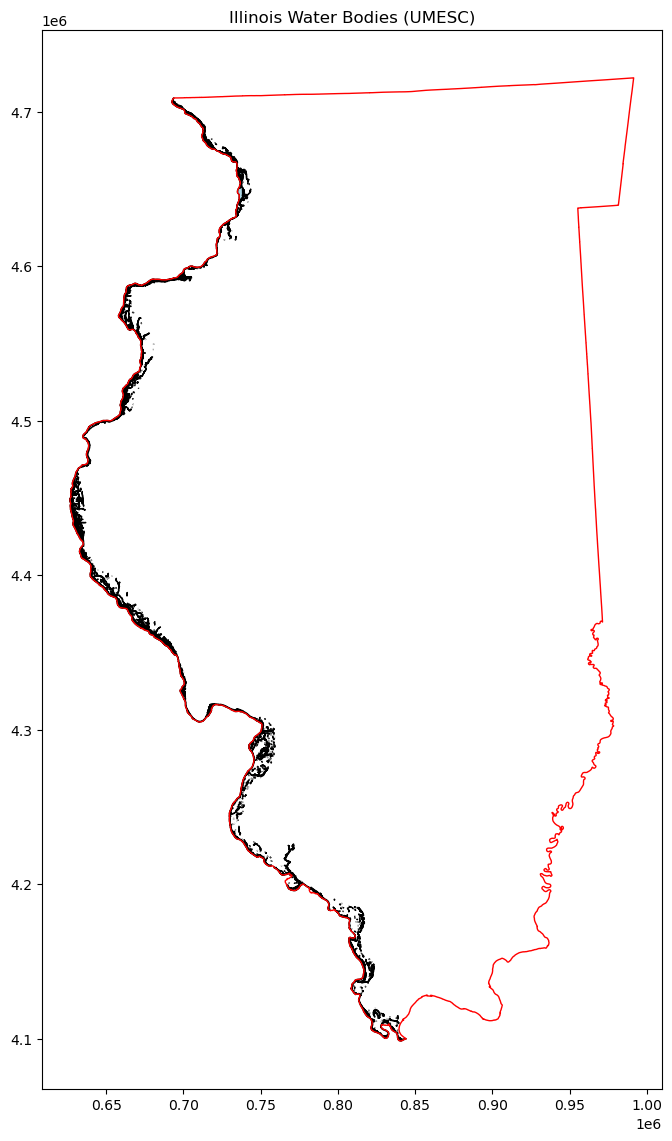

In [7]:
# Cell 3: Extract Illinois water portion
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(url)
illinois = states[states["NAME"] == "Illinois"].to_crs(target_crs)

# Filter water polygons only
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()
water_il = gpd.clip(water_only, illinois)

# Plot check
ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Illinois Water Bodies (UMESC)")
plt.show()

In [8]:
print("Number of invalid geometries in water_only:", (~water_only.is_valid).sum())
print("Invalid geometries indices:", water_only[~water_only.is_valid].index)

Number of invalid geometries in water_only: 0
Invalid geometries indices: Index([], dtype='int64')


In [9]:
# Fix invalid geometries using buffer(0) - only if needed
water_only.loc[~water_only.is_valid, "geometry"] = water_only.loc[~water_only.is_valid, "geometry"].buffer(0)

# Verify
print("Invalid geometries after fix:", (~water_only.is_valid).sum())

Invalid geometries after fix: 0


In [10]:
# Ensure Illinois geometry is valid
illinois["geometry"] = illinois["geometry"].buffer(0)

# Perform clip
water_il = gpd.clip(water_only, illinois)

print("Clipped water shapes:", water_il.shape)

Clipped water shapes: (2876, 14)


In [11]:
# Combine all Illinois water polygons into a single geometry
river_il = water_il.union_all()
print(type(river_il))
print("Bounds of Illinois river section:", river_il.bounds)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
Bounds of Illinois river section: (626594.3664122473, 4098437.22724262, 844182.0029604747, 4708927.272888837)


In [12]:
# Automatic date parsing
tornadoes = pd.read_csv(tornado_csv, parse_dates=['date'])

# Filter by states, EF-scale, and date (can include stronger tornadoes on map, if necessary / min_date will likely be changed)
tornadoes = tornadoes[
    tornadoes['st'].isin(states_of_interest) &
    tornadoes['mag'].isin([0, 1]) &
    (tornadoes['date'] >= min_date)
]

print("Filtered tornadoes:", tornadoes.shape)
tornadoes

Filtered tornadoes: (6565, 29)


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
9,201,1950,12,2,1950-12-02,17:30:00,3,IL,17,9,...,9.60,50,1,1,1,157,0,0,0,0
114,75,1950,5,4,1950-05-04,21:00:00,3,IA,19,1,...,0.10,10,1,1,1,129,0,0,0,0
134,135,1950,6,13,1950-06-13,03:00:00,3,IL,17,5,...,0.10,10,1,1,1,15,0,0,0,0
139,140,1950,6,15,1950-06-15,01:00:00,3,MO,29,4,...,0.20,100,1,1,1,205,0,0,0,0
160,133,1950,6,9,1950-06-09,13:00:00,3,MO,29,3,...,2.70,220,1,1,1,169,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71664,624857,2024,8,15,2024-08-15,22:06:00,3,IL,17,0,...,3.20,50,1,1,1,175,0,0,0,0
71687,624880,2024,8,30,2024-08-30,11:45:00,3,IL,17,0,...,0.08,20,1,1,1,157,0,0,0,0
71712,624820,2024,8,5,2024-08-05,20:57:00,3,IA,19,0,...,0.33,30,1,1,1,191,0,0,0,0
71713,624821,2024,8,5,2024-08-05,21:11:00,3,IA,19,0,...,0.98,80,1,1,1,191,0,0,0,0


In [13]:
# Remove any rows with missing or invalid coordinates
coord_cols = ['slon', 'slat', 'elon', 'elat']
tornadoes = tornadoes.dropna(subset=coord_cols)

# Remove out-of-bounds or unrealistic coordinates
tornadoes = tornadoes[
    (tornadoes['slon'].between(-180, 180)) &
    (tornadoes['elon'].between(-180, 180)) &
    (tornadoes['slat'].between(-90, 90)) &
    (tornadoes['elat'].between(-90, 90))
]
print("After coordinate cleaning:", tornadoes.shape)

After coordinate cleaning: (6565, 29)


In [14]:
# --- Fix 1: Convert positive longitudes (U.S. longitudes are negative west of Greenwich) ---
tornadoes['slon'] = tornadoes['slon'].apply(lambda x: -x if x > 0 else x)
tornadoes['elon'] = tornadoes['elon'].apply(lambda x: -x if x > 0 else x)

# --- Fix 2: Remove zero or missing coordinates (invalid positions) ---
tornadoes.loc[tornadoes['slat'] == 0, 'slat'] = np.nan
tornadoes.loc[tornadoes['elat'] == 0, 'elat'] = np.nan
tornadoes.loc[tornadoes['slon'] == 0, 'slon'] = np.nan
tornadoes.loc[tornadoes['elon'] == 0, 'elon'] = np.nan

# Drop rows with NaNs after cleaning
tornadoes = tornadoes.dropna(subset=['slon', 'slat', 'elon', 'elat']).copy()

# Check coordinate ranges again
print("Longitude range (fixed):", tornadoes[['slon', 'elon']].min().min(), "to", tornadoes[['slon', 'elon']].max().max())
print("Latitude range (fixed):", tornadoes[['slat', 'elat']].min().min(), "to", tornadoes[['slat', 'elat']].max().max())

Longitude range (fixed): -96.6 to -87.0264
Latitude range (fixed): 36.0022 to 43.5808


In [15]:
from shapely.geometry import LineString, Point
import geopandas as gpd

# Create LineString or Point geometries
def make_geom(row):
    if pd.isna(row['elon']) or pd.isna(row['elat']) or \
       (row['elon'] == row['slon'] and row['elat'] == row['slat']):
        return Point(row['slon'], row['slat'])
    else:
        return LineString([(row['slon'], row['slat']), (row['elon'], row['elat'])])

tornadoes['geometry'] = tornadoes.apply(make_geom, axis=1)

# Convert to GeoDataFrame
tornado_gdf = gpd.GeoDataFrame(tornadoes, geometry='geometry', crs="EPSG:4326")

# Reproject to match water shapefile CRS
tornado_gdf = tornado_gdf.to_crs(target_crs)

print("Tornado geometries rebuilt")
print("Geometry types:", tornado_gdf.geometry.geom_type.value_counts())
print("Bounds:", tornado_gdf.total_bounds)

Tornado geometries rebuilt
Geometry types: LineString    3437
Point         1041
Name: count, dtype: int64
Bounds: [ 205367.62901075 3987738.95756939  998831.73103427 4825616.92404392]


In [16]:
# Fix invalid water polygons
water_il['geometry'] = water_il['geometry'].buffer(0)

# Merge into single geometry
river_il_geom = water_il.geometry.union_all()  # or .union_all() if using new shapely

# Ensure the final geometry is valid
from shapely.validation import make_valid
river_il_geom = make_valid(river_il_geom)

In [17]:
# Buffer by 10 km
river_buffer = river_il_geom.buffer(10000)  # adjust as needed

# Check intersections with buffer
tornado_gdf['crosses_river'] = tornado_gdf.intersects(river_buffer)
crossings = tornado_gdf[tornado_gdf['crosses_river']]

print("Total weak tornadoes crossing Mississippi River or intersecting buffered zone:", crossings.shape[0])
print("Counts by EF-scale:\n", crossings['mag'].value_counts())

Total weak tornadoes crossing Mississippi River or intersecting buffered zone: 246
Counts by EF-scale:
 mag
0    124
1    122
Name: count, dtype: int64


In [18]:
#Quick sanity to make sure the river buffer is actually or approximately ~10 km (and in the right units). 

from shapely.ops import nearest_points

# Pick a point on the river geometry
river_point = river_il_geom.representative_point()

# Pick nearest point on the buffer boundary
buffer_boundary = river_buffer.boundary
nearest = nearest_points(river_point, buffer_boundary)[1]

# Compute distance in meters (UTM units)
distance_m = river_point.distance(nearest)
distance_km = distance_m / 1000
print(f"Distance from river to buffer boundary: {distance_km:.2f} km")

Distance from river to buffer boundary: 10.67 km


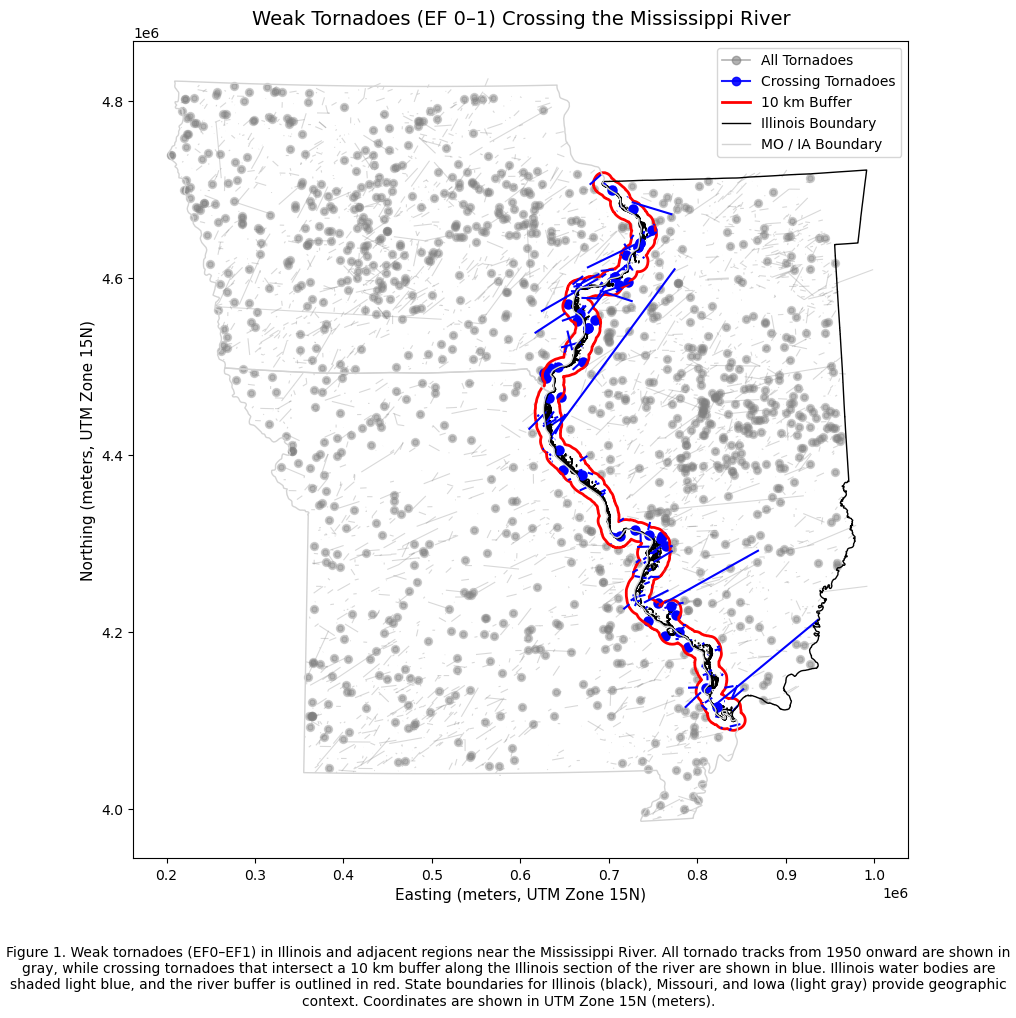

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))

# Plot Illinois water and river buffer
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')

# Plot all tornadoes (lines + points)
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
tornado_gdf[tornado_gdf.geometry.geom_type == 'Point'].plot(ax=ax, color='gray', markersize=15, alpha=0.4)

# Plot crossing tornadoes (lines + points)
crossings.plot(ax=ax, color='blue', linewidth=1.5)
crossings[crossings.geometry.geom_type == 'Point'].plot(ax=ax, color='blue', markersize=25)

# Plot Illinois, Missouri, and Iowa boundaries
illinois.boundary.plot(ax=ax, color='black', linewidth=1, label='Illinois Boundary')

states_path = "/home/njm12/ATMS_596/ne_10m_admin_1_states_provinces.shp"
states = gpd.read_file(states_path).to_crs(target_crs)
states_mo_ia = states[states['name'].isin(['Missouri', 'Iowa'])]
states_mo_ia.boundary.plot(ax=ax, color='lightgray', linewidth=1, label='MO / IA Boundary')

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# --- Labels, title, and caption ---
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title("Weak Tornadoes (EF 0–1) Crossing the Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Easting (meters, UTM Zone 15N)", fontsize=11)
ax.set_ylabel("Northing (meters, UTM Zone 15N)", fontsize=11)

# Figure caption
caption = (
    "Figure 1. Weak tornadoes (EF0–EF1) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 1950 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in UTM Zone 15N (meters)."
)
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

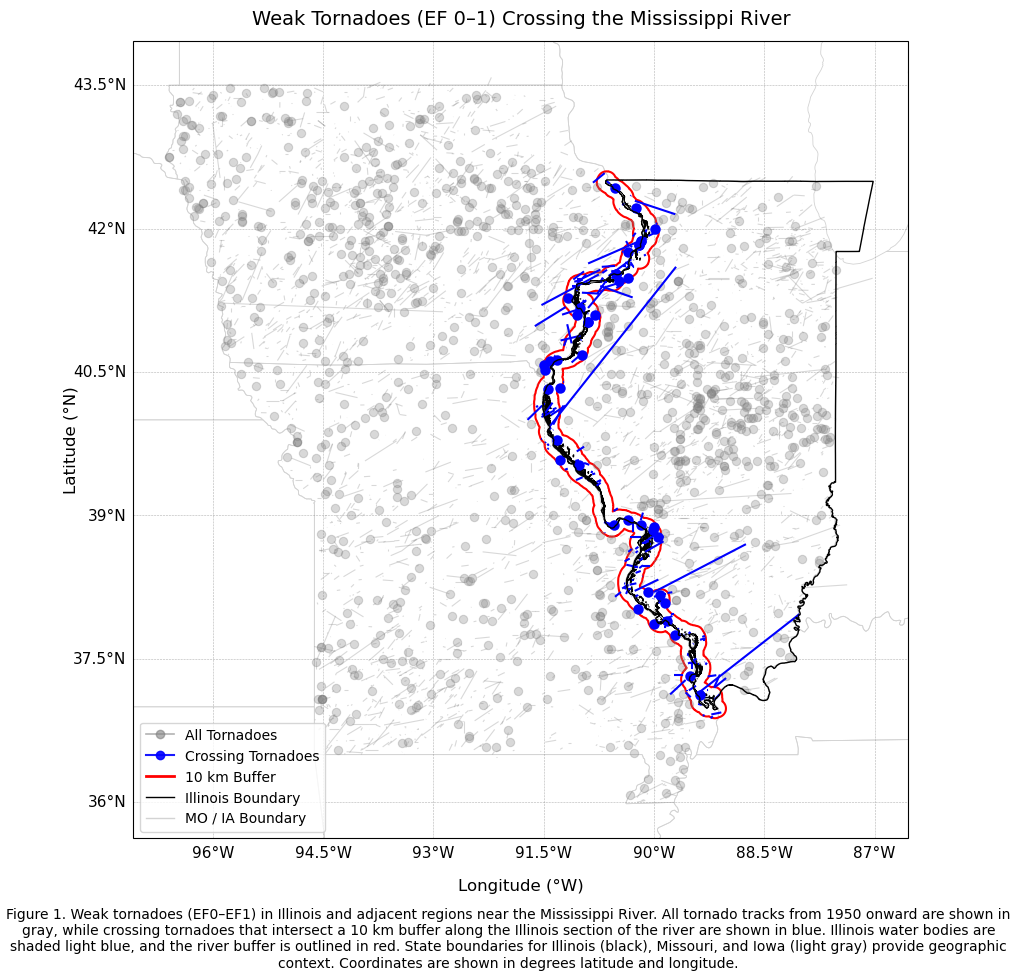

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = tornado_gdf.to_crs("EPSG:4326")
crossings_geo = crossings.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([river_buffer], crs=water_il.crs).to_crs("EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map background
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# Plot layers
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)
tornado_geo.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3, transform=ccrs.PlateCarree(), label='All Tornadoes', zorder=3)
crossings_geo.plot(ax=ax, color='blue', linewidth=1.5, transform=ccrs.PlateCarree(), label='Crossing Tornadoes', zorder=4)
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# Gridlines and coordinate labels
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# Add axis labels manually
ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# Add title and legend
ax.set_title("Weak Tornadoes (EF 0–1) Crossing the Mississippi River", fontsize=14, pad=12)
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Caption
caption = (
    "Figure 1. Weak tornadoes (EF0–EF1) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 1950 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in degrees latitude and longitude."
)
plt.figtext(0.5, 0.12, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

In [21]:
# -------------------------------------------------------------------
# --- Identify west-side, east-side, and crossing weak tornadoes ---
# -------------------------------------------------------------------

# 1. Start with weak tornadoes only (EF 0–1)
weak_tornadoes = tornado_gdf[tornado_gdf["mag"].isin([0, 1])].copy()

# 2. Tornadoes that cross/touch the river (same as before)
crossing_tornadoes = weak_tornadoes[weak_tornadoes.intersects(river_il_geom)]

# 3. Tornadoes that are within or touch the 10 km buffer but do NOT touch/cross the river
buffer_only = weak_tornadoes[
    weak_tornadoes.intersects(river_buffer) & 
    (~weak_tornadoes.intersects(river_il_geom))
].copy()

# 4. Compute centroid of each tornado track for side determination
buffer_only["centroid"] = buffer_only.geometry.centroid

# 5. Determine whether centroids are west or east of the river
#    We'll use the river's centroid X-coordinate as an approximate divider
river_center_x = river_il_geom.centroid.x

west_side = buffer_only[buffer_only["centroid"].x < river_center_x]
east_side = buffer_only[buffer_only["centroid"].x >= river_center_x]

# 6. Print summary results
print("\n--- Weak Tornado Interaction Summary ---")
print(f"Total weak tornadoes: {len(weak_tornadoes)}")
print(f"  • West-side (within/touching 10 km buffer, not touching river): {len(west_side)}")
print(f"  • East-side (within/touching 10 km buffer, not touching river): {len(east_side)}")
print(f"  • Crossing/touching the river: {len(crossing_tornadoes)}")
print(f"  • Sum check: {len(west_side) + len(east_side) + len(crossing_tornadoes)} (should equal 246)")


--- Weak Tornado Interaction Summary ---
Total weak tornadoes: 4478
  • West-side (within/touching 10 km buffer, not touching river): 84
  • East-side (within/touching 10 km buffer, not touching river): 118
  • Crossing/touching the river: 44
  • Sum check: 246 (should equal 246)


In [22]:
# ---------- Robust classification into West Control / East Control / Test (buffer/river) ----------
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Make sure we use the variable names you have defined earlier:
# tornado_gdf  (all tornadoes, already reprojected to target_crs)
# weak_tornadoes (subset of tornado_gdf with mag in [0,1,2])
# river_il_geom  (shapely geometry of Illinois river section)
# river_buffer   (10 km buffer around river_il_geom) -- can be shapely geometry or GeoSeries

# 0) Ensure consistent CRS on weak_tornadoes
weak_tornadoes = weak_tornadoes.to_crs(target_crs)

# 1) Ensure buffer is a single (unary) shapely geometry for intersections
# If river_buffer is a GeoSeries or GeoDataFrame, get the unary_union (or .iloc[0] if single)
try:
    buffer_union = river_buffer
    # if it's a GeoSeries/GeoDataFrame convert to unary_union
    if hasattr(buffer_union, "unary_union"):
        buffer_union = buffer_union.unary_union
except NameError:
    # If river_buffer not available, create from river_il_geom
    buffer_union = river_il_geom.buffer(10000).union()

In [23]:
# 2) Test population: any weak tornado that intersects/touches the buffer OR intersects the river polygon itself
#    (this includes crossings which intersect the river geometry)
test_mask = weak_tornadoes.geometry.intersects(buffer_union) | weak_tornadoes.geometry.intersects(river_il_geom)
test_population = weak_tornadoes[test_mask].copy()

In [24]:
# 3) Outside buffer: those that do NOT intersect the buffer
# Compute side relative to actual river geometry
outside_buffer = weak_tornadoes[~test_mask].copy()

outside_buffer["centroid"] = outside_buffer.geometry.centroid

def assign_west_east(row, river_geom):
    centroid = row.centroid
    nearest = nearest_points(centroid, river_geom)[1]  # nearest point on river
    dx = centroid.x - nearest.x
    return "West Control" if dx < 0 else "East Control"

outside_buffer["side_type"] = outside_buffer.apply(assign_west_east, axis=1, river_geom=river_il_geom)

# Reassign west_control and east_control
west_control = outside_buffer[outside_buffer["side_type"] == "West Control"].copy()
east_control = outside_buffer[outside_buffer["side_type"] == "East Control"].copy()

#Before: split by centroid_x vs a single river_center_x -> vertical line.
#After: split by relative position to nearest river point -> follows meandering river.

In [25]:
# 7) Verify counts and find any unclassified (should not happen, but check)
combined_idx = test_population.index.union(west_control.index).union(east_control.index)
unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
print("Initial sizes:")
print(f"  Test population (intersect buffer/river): {len(test_population)}")
print(f"  West control (outside buffer):            {len(west_control)}")
print(f"  East control (outside buffer):            {len(east_control)}")
print(f"  Unclassified (should be 0):                {len(unclassified)}")
print(f"  Sum categories:                            {len(test_population)+len(west_control)+len(east_control)}")
print(f"  Total weak_tornadoes:                      {len(weak_tornadoes)}")

Initial sizes:
  Test population (intersect buffer/river): 246
  West control (outside buffer):            2719
  East control (outside buffer):            1513
  Unclassified (should be 0):                0
  Sum categories:                            4478
  Total weak_tornadoes:                      4478


In [26]:
# 8) If any unclassified exist (tiny rounding artifacts), assign them deterministically:
if len(unclassified) > 0:
    # compute centroid x for those too
    unclassified["centroid"] = unclassified.geometry.centroid
    unclassified["centroid_x"] = unclassified["centroid"].apply(lambda p: p.x)
    # assign by centroid_x
    assign_west = unclassified[unclassified["centroid_x"] < river_center_x].index
    assign_east = unclassified[unclassified["centroid_x"] >= river_center_x].index
    west_control = pd.concat([west_control, unclassified.loc[assign_west]])
    east_control = pd.concat([east_control, unclassified.loc[assign_east]])
    # recompute combined check
    combined_idx = test_population.index.union(west_control.index).union(east_control.index)
    unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
    print("After deterministic centroid assignment, remaining unclassified:", len(unclassified))
    # If still unclassified (very unlikely), assign by nearest distance to river centerline
    if len(unclassified) > 0:
        # build a river centerline (if you have river_centerline GeoSeries earlier use that)
        try:
            centerline = river_centerline.unary_union
        except Exception:
            # fallback: approximate centerline by taking river_il_geom.representative_point()
            centerline = river_il_geom.representative_point()
        # compute distance to centerline and assign west/east by centroid_x anyway
        for idx, row in unclassified.iterrows():
            cx = row.geometry.centroid.x
            if cx < river_center_x:
                west_control = pd.concat([west_control, row.to_frame().T])
            else:
                east_control = pd.concat([east_control, row.to_frame().T])
        
# final check
combined_idx = test_population.index.union(west_control.index).union(east_control.index)
unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
print("After fallback nearest assignment, remaining unclassified:", len(unclassified))

After fallback nearest assignment, remaining unclassified: 0


In [27]:
# 9) Final assert / sanity check
total_calc = len(test_population) + len(west_control) + len(east_control)
print("\nFinal totals check:")
print(f"  Sum categories = {total_calc}")
print(f"  Total weak_tornadoes = {len(weak_tornadoes)}")
assert total_calc == len(weak_tornadoes), "Final counts DO NOT sum to total weak_tornadoes!"


Final totals check:
  Sum categories = 4478
  Total weak_tornadoes = 4478


In [28]:
# 10) Create breakdown table for EF 0/1
def mag_counts(df):
    # Ensure mag is int-like and only 0/1
    s = df["mag"].astype(int).value_counts().reindex([0, 1], fill_value=0)
    return s.to_dict()

summary = pd.DataFrame({
    "Category": ["West Control", "East Control", "Test (Buffer/River)"],
    "Count": [len(west_control), len(east_control), len(test_population)],
    "EF0": [mag_counts(west_control)[0], mag_counts(east_control)[0], mag_counts(test_population)[0]],
    "EF1": [mag_counts(west_control)[1], mag_counts(east_control)[1], mag_counts(test_population)[1]],
})
summary["Total EF0–EF1"] = summary[["EF0", "EF1"]].sum(axis=1)

# Add totals row
totals = summary[["Count", "EF0", "EF1", "Total EF0–EF1"]].sum()
totals_row = pd.DataFrame([["All Weak Tornadoes", totals["Count"], int(totals["EF0"]), int(totals["EF1"]), int(totals["Total EF0–EF1"])]],
                          columns=summary.columns)
summary = pd.concat([summary, totals_row], ignore_index=True)

print("\n--- Weak Tornado Populations Summary ---")
print(summary.to_string(index=False))


--- Weak Tornado Populations Summary ---
           Category  Count  EF0  EF1  Total EF0–EF1
       West Control   2719 1561 1158           2719
       East Control   1513  885  628           1513
Test (Buffer/River)    246  124  122            246
 All Weak Tornadoes   4478 2570 1908           4478


In [29]:
# --- 1. Prepare data ---
# Add side_type column for clarity
weak_tornadoes["side_type"] = "Unclassified"
weak_tornadoes.loc[weak_tornadoes.index.isin(west_control.index), "side_type"] = "West Control"
weak_tornadoes.loc[weak_tornadoes.index.isin(east_control.index), "side_type"] = "East Control"
weak_tornadoes.loc[weak_tornadoes.index.isin(test_population.index), "side_type"] = "Test (Buffer/River)"

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = weak_tornadoes.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([buffer_union], crs=water_il.crs).to_crs("EPSG:4326")

# Split tornadoes by category for plotting
west_geo = tornado_geo[tornado_geo["side_type"] == "West Control"]
east_geo = tornado_geo[tornado_geo["side_type"] == "East Control"]
test_geo = tornado_geo[tornado_geo["side_type"] == "Test (Buffer/River)"]

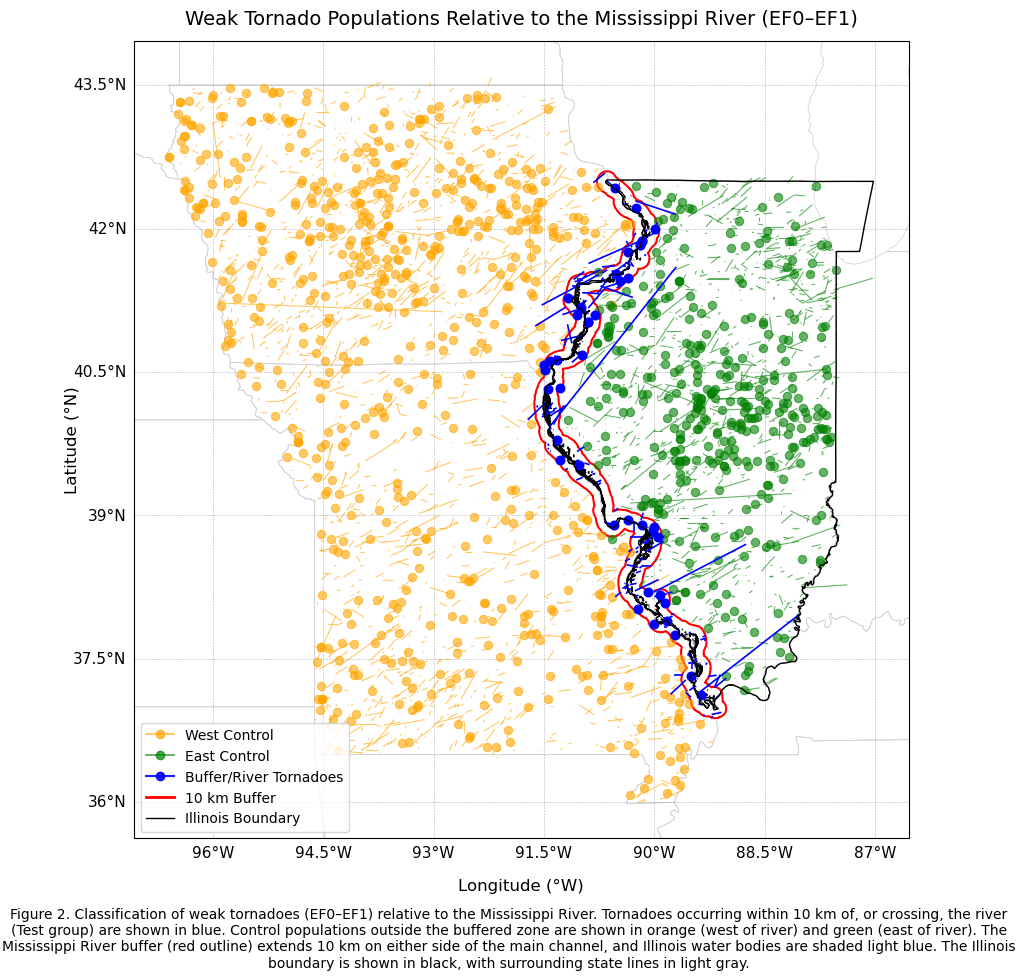

In [30]:
# --- 2. Plot setup ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Background features
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# --- 3. Plot data layers ---
# Base river and buffer
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)

# Tornado groups
west_geo.plot(ax=ax, color='orange', linewidth=0.8, alpha=0.6, transform=ccrs.PlateCarree(), label='West Control', zorder=3)
east_geo.plot(ax=ax, color='green', linewidth=0.8, alpha=0.6, transform=ccrs.PlateCarree(), label='East Control', zorder=3)
test_geo.plot(ax=ax, color='blue', linewidth=1.2, transform=ccrs.PlateCarree(), label='Buffer/River Tornadoes', zorder=4)

# State boundaries
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# --- 4. Gridlines and labels ---
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- 5. Custom legend ---
legend_elements = [
    Line2D([0], [0], color='orange', linewidth=1.2, marker='o', markersize=6, label='West Control', alpha=0.7),
    Line2D([0], [0], color='green', linewidth=1.2, marker='o', markersize=6, label='East Control', alpha=0.7),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, label='Buffer/River Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)
ax.set_title("Weak Tornado Populations Relative to the Mississippi River (EF0–EF1)", fontsize=14, pad=12)

# --- 6. Caption ---
caption = (
    "Figure 2. Classification of weak tornadoes (EF0–EF1) relative to the Mississippi River. "
    "Tornadoes occurring within 10 km of, or crossing, the river (Test group) are shown in blue. "
    "Control populations outside the buffered zone are shown in orange (west of river) and green (east of river). "
    "The Mississippi River buffer (red outline) extends 10 km on either side of the main channel, and Illinois water "
    "bodies are shaded light blue. The Illinois boundary is shown in black, with surrounding state lines in light gray."
)
plt.figtext(0.5, 0.12, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

In [31]:
# --------------------------------------------------------------
# 1) RANDOM SAMPLING (246 each)
# --------------------------------------------------------------

# Fix seed for reproducibility
np.random.seed(42)

random_west_control = west_control.sample(n=246, replace=False, random_state=42)
random_east_control = east_control.sample(n=246, replace=False, random_state=42)

print("\n--- Random West Control Sample (246) ---")
print(random_west_control[["om", "yr", "mo", "dy", "mag", "slat", "slon", "elat", "elon"]].head(10).to_string(index=False))

print("\n--- Random East Control Sample (246) ---")
print(random_east_control[["om", "yr", "mo", "dy", "mag", "slat", "slon", "elat", "elon"]].head(10).to_string(index=False))

# --------------------------------------------------------------
# 2) REPROJECT RANDOM SUBSETS FOR PLOTTING
# --------------------------------------------------------------

random_west_geo = random_west_control.to_crs("EPSG:4326")
random_east_geo = random_east_control.to_crs("EPSG:4326")
test_geo = test_geo.to_crs("EPSG:4326")  # already defined earlier

water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([buffer_union], crs=water_il.crs).to_crs("EPSG:4326")


--- Random West Control Sample (246) ---
    om   yr  mo  dy  mag    slat     slon    elat     elon
   713 2001   4  11    0 41.8500 -91.7000 41.8500 -91.7000
   105 1998   4   7    1 40.3800 -91.6000 40.3800 -91.5800
619123 2020   5  26    0 41.6119 -93.8862 41.6245 -93.8935
   742 2001   5   4    0 40.1700 -95.0300 40.1800 -95.0500
432083 2013   1  29    0 38.9113 -90.8106 38.9282 -90.7887
   240 2007   3  31    0 42.7000 -91.9300 42.7000 -91.9300
382751 2012   5   4    0 43.0900 -95.6900 43.0900 -95.6800
   183 2010   4  30    1 36.6379 -92.2898 36.7634 -92.1660
  1254 2010  12  30    1 36.5706 -93.3742 36.6127 -93.3541
   597 1994   6  26    1 37.5500 -91.6700 37.5800 -91.6200

--- Random East Control Sample (246) ---
    om   yr  mo  dy  mag    slat     slon    elat     elon
504203 2014   4   3    0 37.5092 -89.1670 37.5701 -89.1167
  1309 2004   6  10    0 39.9700 -88.1700 39.9700 -88.1500
  1401 2008   8   4    1 41.9400 -88.0900 41.9400 -88.0800
374447 2012   5   6    0 40.457

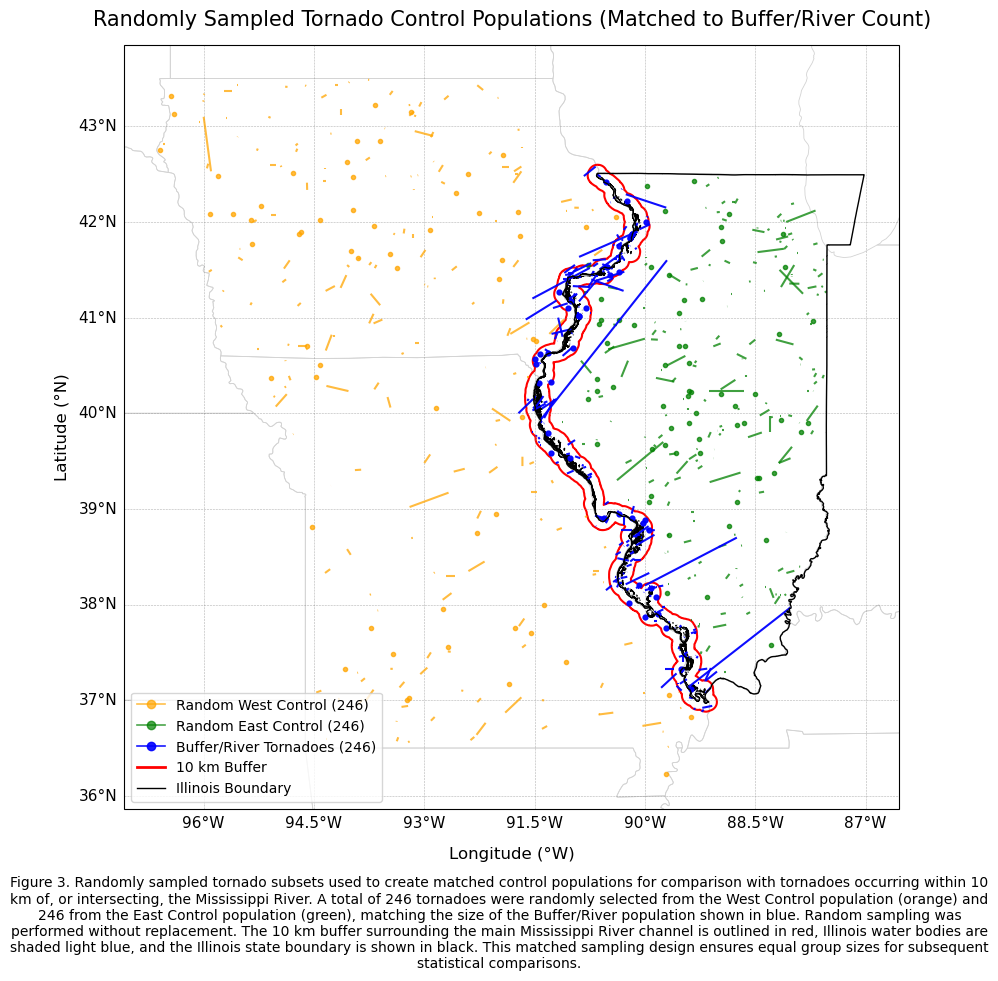

In [32]:
# --------------------------------------------------------------
# 3) PLOT THE NEW RANDOM SUBSETS
# --------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Background
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="lightgray", linewidth=0.6)

# Water + buffer
water_il_geo.plot(ax=ax, color="lightblue", edgecolor="k", transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color="red", linewidth=1.5, transform=ccrs.PlateCarree(),
                               label="10 km Buffer", zorder=2)

# Tornado subsets (random)
random_west_geo.plot(ax=ax, color="orange", markersize=9, alpha=0.75,
                     transform=ccrs.PlateCarree(), label="Random West Control (246)", zorder=3)

random_east_geo.plot(ax=ax, color="green", markersize=9, alpha=0.75,
                     transform=ccrs.PlateCarree(), label="Random East Control (246)", zorder=3)

# Test group (full)
test_geo.plot(ax=ax, color="blue", markersize=12, alpha=0.95,
              transform=ccrs.PlateCarree(), label="Buffer/River Tornadoes (246)", zorder=4)

# Illinois boundary
illinois_geo.boundary.plot(ax=ax, color="black", linewidth=1,
                           transform=ccrs.PlateCarree(), zorder=5)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", alpha=0.6, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 11}
gl.ylabel_style = {"size": 11}

ax.text(0.5, -0.06, "Longitude (°W)", ha="center", va="center", fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, "Latitude (°N)", ha="center", va="center", rotation="vertical",
        fontsize=12, transform=ax.transAxes)

# Legend
legend_elements = [
    Line2D([0], [0], color="orange", marker='o', lw=1.2, markersize=6,
           label="Random West Control (246)", alpha = 0.7),
    Line2D([0], [0], color="green", marker='o', lw=1.2, markersize=6,
           label="Random East Control (246)", alpha = 0.7),
    Line2D([0], [0], color="blue", marker='o', lw=1.2, markersize=6,
           label="Buffer/River Tornadoes (246)", alpha = 0.9),
    Line2D([0], [0], color="red", linewidth=2, label="10 km Buffer"),
    Line2D([0], [0], color="black", linewidth=1, label="Illinois Boundary"),
]

ax.legend(handles=legend_elements, loc="lower left", fontsize=10, frameon=True)

ax.set_title("Randomly Sampled Tornado Control Populations (Matched to Buffer/River Count)",
             fontsize=15, pad=14)

# --------------------------------------------------------------
# 4) FIGURE CAPTION
# --------------------------------------------------------------

caption = (
    "Figure 3. Randomly sampled tornado subsets used to create matched control populations for "
    "comparison with tornadoes occurring within 10 km of, or intersecting, the Mississippi River. "
    "A total of 246 tornadoes were randomly selected from the West Control population (orange) and "
    "246 from the East Control population (green), matching the size of the Buffer/River population "
    "shown in blue. Random sampling was performed without replacement. The 10 km buffer surrounding "
    "the main Mississippi River channel is outlined in red, Illinois water bodies are shaded light "
    "blue, and the Illinois state boundary is shown in black. This matched sampling design ensures "
    "equal group sizes for subsequent statistical comparisons."
)

plt.figtext(0.5, 0.11, caption, wrap=True, ha="center", fontsize=10)

plt.show()

Total tornadoes in full-population boxplot: 4478


/tmp/ipykernel_841/4203414966.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




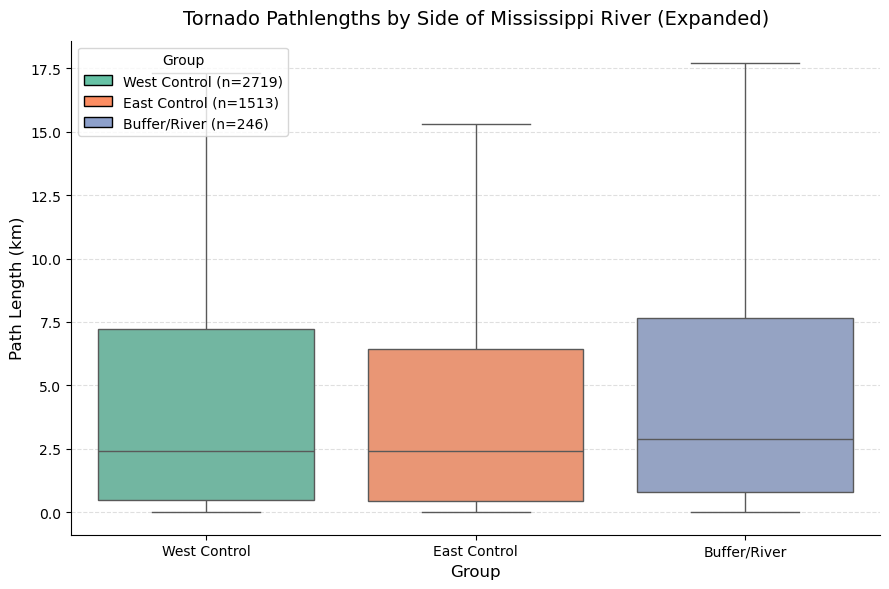


Five-number summary (km) for original populations:
              Min        Q1    Median        Q3         Max
side_type                                                  
Buffer/River  0.0  0.804670  2.896812  7.640342  237.216716
East Control  0.0  0.450615  2.414010  6.437360  189.741186
West Control  0.0  0.482802  2.414010  7.225937   91.732380


In [33]:
# --- Step 1: Prepare DataFrames for plotting ---

# Original West Control
west_full_plot = west_control[['len']].copy()
west_full_plot['side_type'] = "West Control"

# Original East Control
east_full_plot = east_control[['len']].copy()
east_full_plot['side_type'] = "East Control"

# Buffer/River (372 tornadoes)
test_plot_full = test_population[['len']].copy()
test_plot_full['side_type'] = "Buffer/River"

# --- Step 2: Convert pathlength miles → kilometers ---
for df in [west_full_plot, east_full_plot, test_plot_full]:
    df['len'] = df['len'] * 1.60934

# --- Step 3: Combine datasets ---
plot_df_full = pd.concat([west_full_plot, east_full_plot, test_plot_full], ignore_index=True)

print("Total tornadoes in full-population boxplot:", len(plot_df_full))

# --- Step 4: Create boxplot ---
plt.figure(figsize=(9, 6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=plot_df_full,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False
)

# --- Step 5: Legend with actual sample sizes ---
counts_full = plot_df_full["side_type"].value_counts()

legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{category} (n={counts_full[category]})")
    for i, category in enumerate(['West Control', 'East Control', 'Buffer/River'])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# --- Step 6: Formatting ---
ax.set_title("Tornado Pathlengths by Side of Mississippi River (Expanded)", 
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 7: Five-number summary ---
summary_stats_full = (
    plot_df_full.groupby("side_type")['len']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats_full.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary (km) for original populations:")
print(summary_stats_full)

In [34]:
# -----------------------------------------------------------
# Use full-population dataset created earlier:
# plot_df_full includes:
# - West Control
# - East Control
# - Buffer/River
# -----------------------------------------------------------

groups_full = plot_df_full.groupby('side_type')['len'].apply(list)

# Extract groups
west_len = groups_full['West Control']
east_len = groups_full['East Control']
buffer_len = groups_full['Buffer/River']

# --- 1. Overall Kruskal-Wallis test ---
stat, p = kruskal(west_len, east_len, buffer_len)

print(f"Overall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# --- 2. Pairwise tests ---
pairs = list(itertools.combinations(groups_full.index, 2))
results = []

for a, b in pairs:
    stat_ab, p_ab = kruskal(groups_full[a], groups_full[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': stat_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal-Wallis test: H = 5.636, p = 0.0597

Pairwise Kruskal-Wallis results:
         Group1        Group2         H   p-value Significant?
0  Buffer/River  East Control  4.420858  0.035502          Yes
1  Buffer/River  West Control  2.043057  0.152902           No
2  East Control  West Control  2.695676  0.100621           No


### Kruskal-Wallis Test on Tornado Path Lengths 

**Overall Test:**
- **Kruskal–Wallis H = 5.636**, **p = 0.0597**
- **Interpretation:** At the 0.05 significance level, there is **no statistically significant overall difference** in tornado path lengths among the three groups (West Control, East Control, Buffer/River), though pairwise differences exist.

**Pairwise Comparisons:**

| Group 1       | Group 2            | H        | p-value     | Significant? |
|---------------|--------------------|----------|-------------|--------------|
| Buffer/River  | East Control       | 4.421    | 0.035502    | Yes          |
| Buffer/River  | West Control       | 2.043    | 0.152902    | No           |
| East Control  | West Control       | 2.696    | 0.100621    | No           |

**Summary:**
- The **Buffer/River** group differs significantly **only from the East Control** group.
- Differences between **Buffer/River vs. West Control** and **East vs. West Control** are **not statistically significant**.
- Overall, when using **random subsampled control groups**, tornado pathlength distributions across the three categories show **limited evidence of systematic differences**, with significance emerging only in one pairwise comparison.

Total tornadoes included in expanded box plot: 738


/tmp/ipykernel_841/2903066647.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




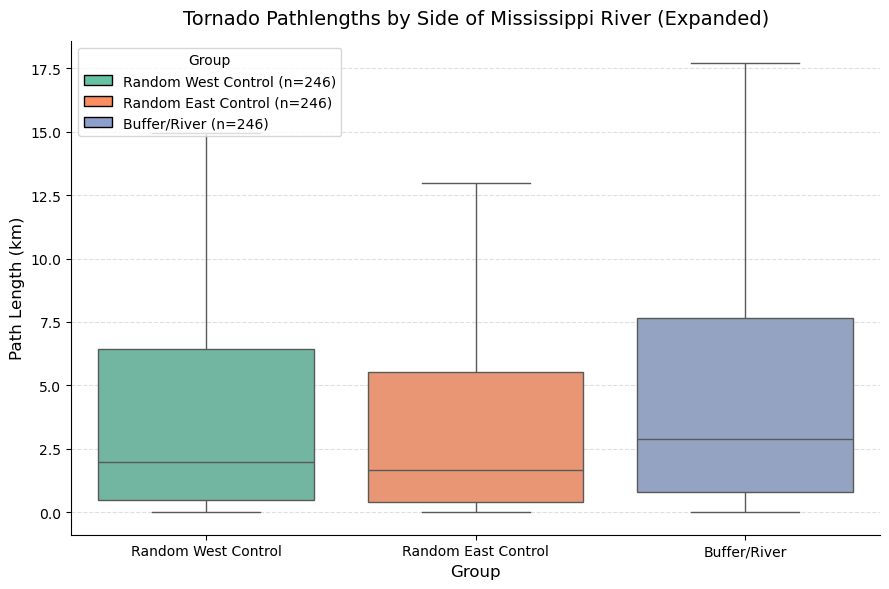


Five-number summary for tornado pathlengths (km):
                          Min        Q1    Median        Q3         Max
side_type                                                              
Buffer/River         0.000000  0.804670  2.896812  7.640342  237.216716
Random East Control  0.016093  0.410382  1.657620  5.544176   70.006290
Random West Control  0.000000  0.482802  1.987535  6.437360   59.545580


In [35]:
# --- Step 1: Prepare each subset for plotting ---

# West Control (random sample, 246 tornadoes)
west_plot = random_west_control[['len']].copy()
west_plot['side_type'] = "Random West Control"

# East Control (random sample, 246 tornadoes)
east_plot = random_east_control[['len']].copy()
east_plot['side_type'] = "Random East Control"

# Test population (Buffer + River intersections, 246 tornadoes)
test_plot = test_population[['len']].copy()
test_plot['side_type'] = "Buffer/River"

# --- Step 2: Convert pathlength from miles → kilometers ---
for df in [west_plot, east_plot, test_plot]:
    df['len'] = df['len'] * 1.60934  # mi → km

# --- Step 3: Combine all three categories ---
plot_df = pd.concat([west_plot, east_plot, test_plot], ignore_index=True)

print("Total tornadoes included in expanded box plot:", len(plot_df))  # should be 738

# --- Step 4: Create boxplot ---
plt.figure(figsize=(9, 6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=plot_df,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False
)

# --- Step 5: Build custom legend with sample sizes ---
counts = plot_df["side_type"].value_counts()

legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{category} (n={counts[category]})")
    for i, category in enumerate(['Random West Control', 'Random East Control', 'Buffer/River'])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# --- Step 6: Final formatting ---
ax.set_title("Tornado Pathlengths by Side of Mississippi River (Expanded)", 
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 7: Compute five-number summaries for each group ---
summary_stats = (
    plot_df.groupby("side_type")['len']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary for tornado pathlengths (km):")
print(summary_stats)

In [36]:
# -----------------------------------------------------------
# Kruskal-Wallis test for RANDOM subsampled groups (246 each)
# -----------------------------------------------------------

import itertools
from scipy.stats import kruskal

# Group data from the random-sampled plot_df
groups_rand = plot_df.groupby('side_type')['len'].apply(list)

# Extract lists
west_len   = groups_rand['Random West Control']
east_len   = groups_rand['Random East Control']
buffer_len = groups_rand['Buffer/River']

# --- 1. Overall Kruskal-Wallis test ---
stat, p = kruskal(west_len, east_len, buffer_len)

print(f"Overall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# --- 2. Pairwise Kruskal-Wallis tests ---
pairs = list(itertools.combinations(groups_rand.index, 2))
results = []

for a, b in pairs:
    stat_ab, p_ab = kruskal(groups_rand[a], groups_rand[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': stat_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)

print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal-Wallis test: H = 6.193, p = 0.0452

Pairwise Kruskal-Wallis results:
                Group1               Group2         H   p-value Significant?
0         Buffer/River  Random East Control  5.968382  0.014565          Yes
1         Buffer/River  Random West Control  2.481076  0.115223           No
2  Random East Control  Random West Control  0.832567  0.361531           No


### Kruskal-Wallis Test on Tornado Path Lengths  
#### Random Subsampled Groups (246 Tornadoes per Group)

**Overall Test:**
- **Kruskal–Wallis H = 6.193**, **p = 0.0452**
- **Interpretation:** There is a statistically significant difference in tornpath lengthsdths among at least one of the three groups (Buffer/River, Random East Control, Random West Control).

**Pairwise Comparisons:**

| Group 1             | Group 2              | H         | p-value     | Significant? |
|---------------------|----------------------|-----------|-------------|--------------|
| Buffer/River        | Random East Control  | 5.968     | 0.014565    | Yes          |
| Buffer/River        | Random West Control  | 2.481     | 0.115223    | No           |
| Random East Control | Random West Control  | 0.833     | 0.361531    | No           |

**Summarypath lengths Tornado widths in the **Buffer/River** group differ significantly from the **Random East Control** group.
- No statistically significant differences were found between Buffer/River vs. Random West or betweely sampledn the two random control groups.
- Results suggpath lengthsat tornado widths near the Mississippi River differ somewhat from those in randomly sampled regional populations, but the difference is limited to comparisons with the random east-side sample.

Total tornadoes in width plot: 4478


/tmp/ipykernel_841/2631839374.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




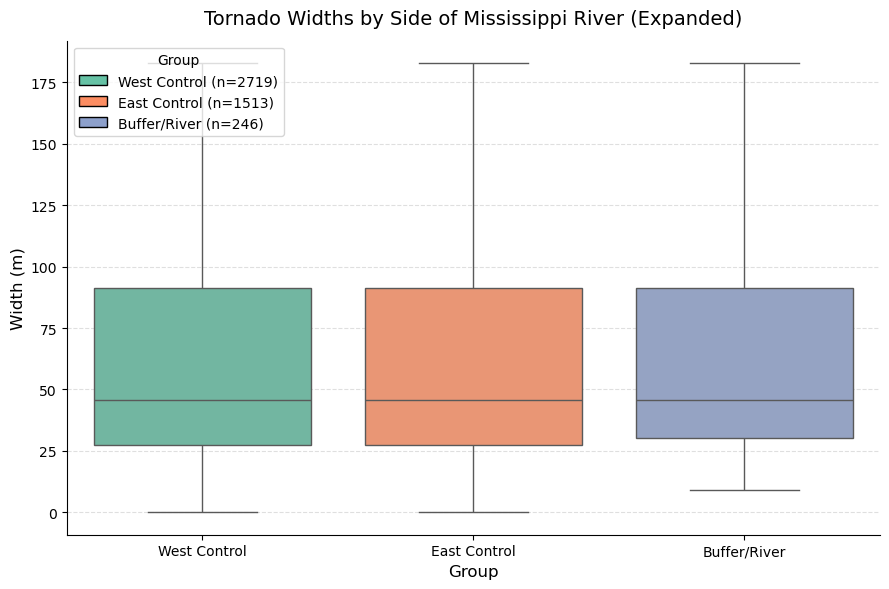


Five-number summary for tornado widths (m):

                Min       Q1  Median     Q3       Max
side_type                                            
Buffer/River  9.144  30.1752   45.72  91.44   804.672
East Control  0.000  27.4320   45.72  91.44  1188.720
West Control  0.000  27.4320   45.72  91.44  1463.040


In [37]:
# -----------------------------------------------------------
# Boxplot of Tornado Width by Side of Mississippi River
# Using ORIGINAL full West/East control populations
# -----------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# --- Step 1: Prepare each dataset ---

# Original West Control population
orig_west_width = west_control[['wid']].copy()
orig_west_width['width_m'] = orig_west_width['wid'] * 0.9144  # yards → meters
orig_west_width['side_type'] = "West Control"

# Original East Control population
orig_east_width = east_control[['wid']].copy()
orig_east_width['width_m'] = orig_east_width['wid'] * 0.9144  # yards → meters
orig_east_width['side_type'] = "East Control"

# Buffer/River Test population (unchanged)
test_width_full = test_population[['wid']].copy()
test_width_full['width_m'] = test_width_full['wid'] * 0.9144  # yards → meters
test_width_full['side_type'] = "Buffer/River"

# Combine datasets
width_plot_full = pd.concat(
    [orig_west_width, orig_east_width, test_width_full],
    ignore_index=True
)

print("Total tornadoes in width plot:", len(width_plot_full))

# --- Step 2: Create boxplot ---
plt.figure(figsize=(9,6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=width_plot_full,
    x="side_type",
    y="width_m",
    palette=palette,
    showfliers=False
)

# --- Step 3: Legend with counts ---
counts_full = width_plot_full['side_type'].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts_full[cat]})")
    for i, cat in enumerate(['West Control', 'East Control', 'Buffer/River'])
]

ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    title="Group",
    frameon=True
)

# --- Step 4: Formatting ---
ax.set_title("Tornado Widths by Side of Mississippi River (Expanded)", fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 5: Five-number summary ---
width_summary_full = (
    width_plot_full.groupby("side_type")['width_m']
    .describe(percentiles=[0.25,0.5,0.75])
    [['min','25%','50%','75%','max']]
)

width_summary_full.columns = ['Min','Q1','Median','Q3','Max']

print("\nFive-number summary for tornado widths (m):\n")
print(width_summary_full)

In [38]:
# -----------------------------------------------------------
# Kruskal–Wallis tests for ORIGINAL full populations (widths)
# -----------------------------------------------------------

# Group widths into lists
groups_full_width = width_plot_full.groupby("side_type")['width_m'].apply(list)

west_full = groups_full_width['West Control']
east_full = groups_full_width['East Control']
buffer_full = groups_full_width['Buffer/River']

# --- Overall Kruskal–Wallis test ---
H_full, p_full = kruskal(west_full, east_full, buffer_full)

print(f"Overall Kruskal–Wallis test: H = {H_full:.3f}, p = {p_full:.6f}\n")

# --- Pairwise comparisons ---
pairs = list(itertools.combinations(groups_full_width.index, 2))
pairwise_results_full = []

for g1, g2 in pairs:
    H, p = kruskal(groups_full_width[g1], groups_full_width[g2])
    pairwise_results_full.append({
        "Group1": g1,
        "Group2": g2,
        "H": H,
        "p-value": p,
        "Significant?": "Yes" if p < 0.05 else "No"
    })

pairwise_full_df = pd.DataFrame(pairwise_results_full)

print("Pairwise Kruskal–Wallis results:")
print(pairwise_full_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal–Wallis test: H = 2.208, p = 0.331563

Pairwise Kruskal–Wallis results:
         Group1        Group2         H   p-value Significant?
0  Buffer/River  East Control  1.163651  0.280710           No
1  Buffer/River  West Control  0.502352  0.478468           No
2  East Control  West Control  1.508185  0.219416           No


### Kruskal-Wallis Test on Tornado Widths — Weak Tornadoes Only (EF0–EF1, Full Populations)

**Overall Test:**
- Kruskal-Wallis H = 2.208 , p = 0.331563
- Interpretation: No statistically significant differences were detected among the three groups (p > 0.05).

**Pairwise Comparisons:**

| Group 1       | Group 2      | H        | p-value   | Significant? |
|---------------|--------------|----------|-----------|--------------|
| West Control  | East Control | 1.508185 | 0.219416  | No           |
| West Control  | Buffer/River | 0.502352 | 0.478468  | No           |
| East Control  | Buffer/River | 1.163651 | 0.280710  | No           |

**Summary:**
- No pairwise group differences were statistically significant.
- Weak-tornado widths appear similar across West Control, East Control, and Buffer/River when using the full population.


Total tornadoes in width plot: 738


/tmp/ipykernel_841/1744008113.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




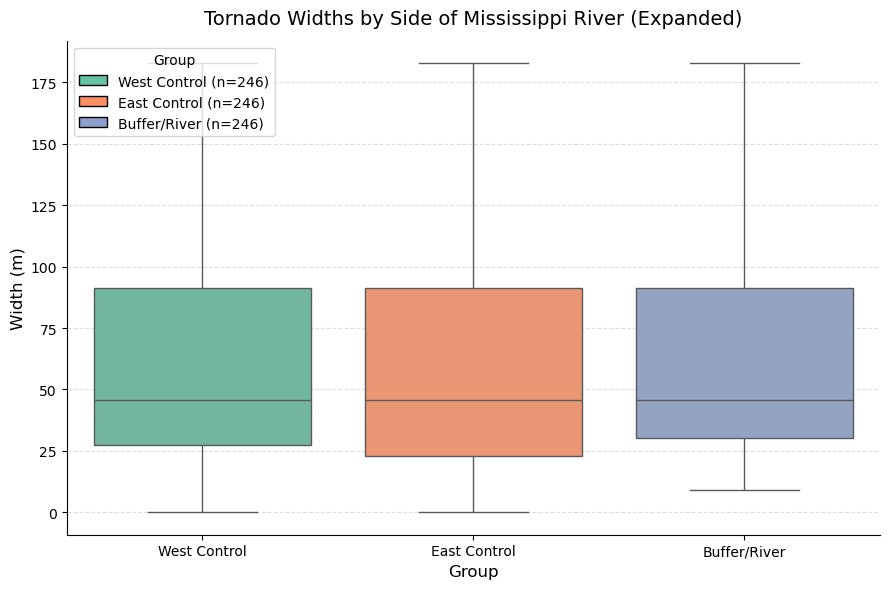


Five-number summary for tornado widths (m):

                Min       Q1  Median     Q3       Max
side_type                                            
Buffer/River  9.144  30.1752   45.72  91.44   804.672
East Control  0.000  22.8600   45.72  91.44   914.400
West Control  0.000  27.4320   45.72  91.44  1207.008


In [39]:
# -----------------------------------------------------------
# Boxplot of Tornado Width by Side of Mississippi River
# Expanded sample: West Control, East Control, Buffer/River
# -----------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# --- Step 1: Prepare each dataset ---

# West Control (246 tornadoes)
west_width = random_west_control[['wid']].copy()
west_width['width_m'] = west_width['wid'] * 0.9144   # yards → meters
west_width['side_type'] = "West Control"

# East Control (246 tornadoes)
east_width = random_east_control[['wid']].copy()
east_width['width_m'] = east_width['wid'] * 0.9144   # yards → meters
east_width['side_type'] = "East Control"

# Buffer + River Test population (246 tornadoes)
test_width = test_population[['wid']].copy()
test_width['width_m'] = test_width['wid'] * 0.9144   # yards → meters
test_width['side_type'] = "Buffer/River"

# Combine into one DataFrame
width_plot_df = pd.concat([west_width, east_width, test_width], ignore_index=True)

print("Total tornadoes in width plot:", len(width_plot_df))  # Expected: 738

# --- Step 2: Create boxplot ---
plt.figure(figsize=(9,6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=width_plot_df,
    x="side_type",
    y="width_m",
    palette=palette,
    showfliers=False
)

# --- Step 3: Legend with counts ---
counts = width_plot_df["side_type"].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts[cat]})")
    for i, cat in enumerate(['West Control', 'East Control', 'Buffer/River'])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# --- Step 4: Formatting ---
ax.set_title("Tornado Widths by Side of Mississippi River (Expanded)", fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 5: Five-number summary statistics ---
width_summary = (
    width_plot_df.groupby("side_type")['width_m']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

width_summary.columns = ['Min','Q1','Median','Q3','Max']

print("\nFive-number summary for tornado widths (m):\n")
print(width_summary)

In [40]:
# -----------------------------------------------------------
# Kruskal–Wallis tests for RANDOM 246-sample populations
# -----------------------------------------------------------

# Group widths into lists
groups_rand_width = width_plot_df.groupby("side_type")['width_m'].apply(list)

west_rand = groups_rand_width['West Control']
east_rand = groups_rand_width['East Control']
buffer_rand = groups_rand_width['Buffer/River']

# --- Overall Kruskal–Wallis test ---
H_rand, p_rand = kruskal(west_rand, east_rand, buffer_rand)

print(f"Overall Kruskal–Wallis test: H = {H_rand:.3f}, p = {p_rand:.6f}\n")

# --- Pairwise comparisons ---
pairs = list(itertools.combinations(groups_rand_width.index, 2))
pairwise_results_rand = []

for g1, g2 in pairs:
    H, p = kruskal(groups_rand_width[g1], groups_rand_width[g2])
    pairwise_results_rand.append({
        "Group1": g1,
        "Group2": g2,
        "H": H,
        "p-value": p,
        "Significant?": "Yes" if p < 0.05 else "No"
    })

pairwise_rand_df = pd.DataFrame(pairwise_results_rand)

print("Pairwise Kruskal–Wallis results:")
print(pairwise_rand_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal–Wallis test: H = 1.749, p = 0.417133

Pairwise Kruskal–Wallis results:
         Group1        Group2         H   p-value Significant?
0  Buffer/River  East Control  1.511391  0.218927           No
1  Buffer/River  West Control  0.943371  0.331412           No
2  East Control  West Control  0.179261  0.672009           No


### Kruskal-Wallis Test on Tornado Widths — Weak Tornadoes Only (EF0–EF1, Random 246-Sample Populations)

**Overall Test:**
- Kruskal-Wallis H = 1.749 , p = 0.417133
- Interpretation: No statistically significant differences were found among the equal-size groups (p > 0.05).

**Pairwise Comparisons:**

| Group 1               | Group 2               | H        | p-value   | Significant? |
|-----------------------|-----------------------|----------|-----------|--------------|
| Random West Control   | Random East Control   | 0.179261 | 0.672009  | No           |
| Random West Control   | Buffer/River          | 0.943371 | 0.331412  | No           |
| Random East Control   | Buffer/River          | 1.511391 | 0.218927  | No           |

**Summary:**
- None of the pairwise comparisons are statistically significant.
- Equalizing the sample sizes (n = 246 each) preserves the same conclusion as the full population: weak-tornado widths do not differ meaningfully between regions.


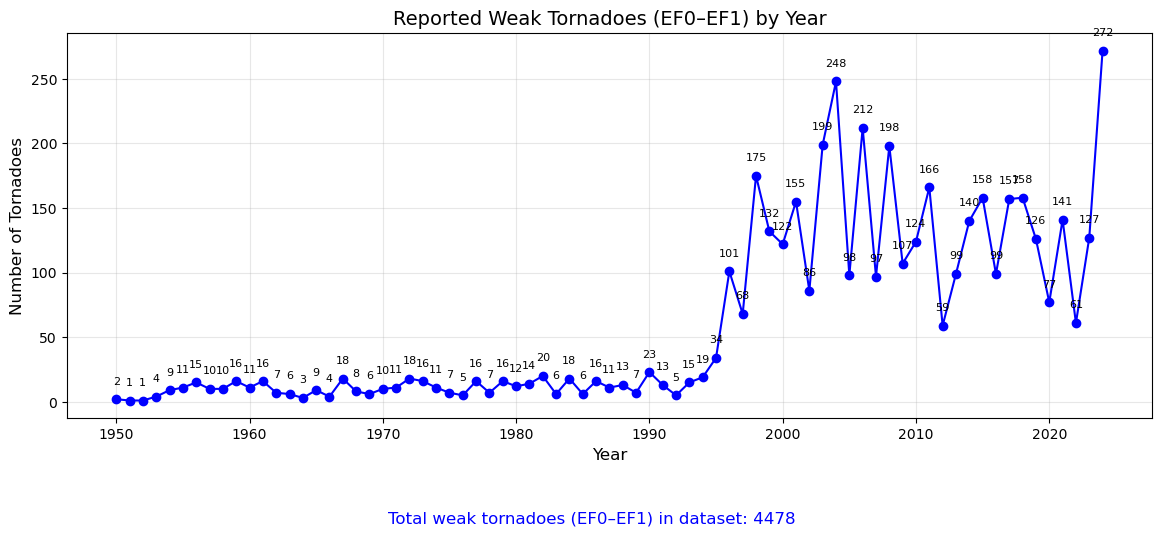

In [41]:
# Extract year from tornado dates
weak_tornadoes["year"] = weak_tornadoes["date"].dt.year

# Group by year
yearly_counts = weak_tornadoes.groupby("year").size()

# Plot timeline
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(yearly_counts.index, yearly_counts.values, marker='o', color='blue', linewidth=1.5)

# Annotate counts above each point
for x, y in zip(yearly_counts.index, yearly_counts.values):
    ax.text(x, y + 10, str(y), ha='center', va='bottom', fontsize=8)

ax.set_title("Reported Weak Tornadoes (EF0–EF1) by Year", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Tornadoes", fontsize=12)
ax.grid(alpha=0.3)

# Add total sum below the plot
total_weak = len(weak_tornadoes)
plt.figtext(0.5, -0.1, f"Total weak tornadoes (EF0–EF1) in dataset: {total_weak}", 
            ha='center', fontsize=12, color='blue')

plt.show()

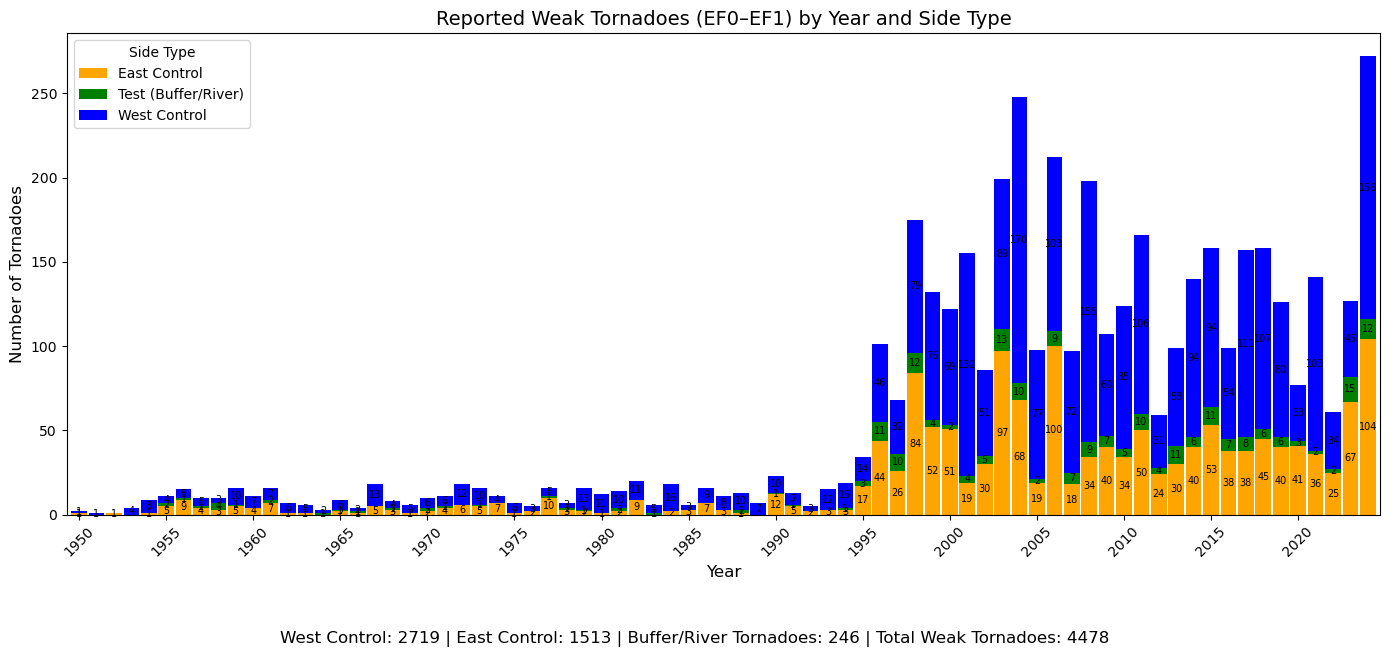

In [42]:
# Group by year and side_type
yearly_side_counts = weak_tornadoes.groupby(["year", "side_type"]).size().unstack(fill_value=0)

# Plot stacked bar chart with wider bars
fig, ax = plt.subplots(figsize=(14, 6))
yearly_side_counts.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=['orange', 'green', 'blue'],
    width=0.9  # wider bars
)

# Annotate counts on each segment (black text)
for i, year in enumerate(yearly_side_counts.index):
    bottom = 0
    for side in yearly_side_counts.columns:
        count = yearly_side_counts.loc[year, side]
        if count > 0:
            ax.text(i, bottom + count / 2, str(count), ha='center', va='center', fontsize=7, color='black')
            bottom += count

ax.set_title("Reported Weak Tornadoes (EF0–EF1) by Year and Side Type", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Tornadoes", fontsize=12)
ax.legend(title="Side Type")

# X-axis ticks every 5 years
years = yearly_side_counts.index
ax.set_xticks([i for i, y in enumerate(years) if y % 5 == 0])
ax.set_xticklabels([y for y in years if y % 5 == 0], rotation=45)

plt.tight_layout()

# Add summed counts below the plot
west_total = len(west_control)
east_total = len(east_control)
test_total = len(test_population)
total_weak = len(weak_tornadoes)
sum_text = (f"West Control: {west_total} | East Control: {east_total} | "
            f"Buffer/River Tornadoes: {test_total} | Total Weak Tornadoes: {total_weak}")
plt.figtext(0.5, -0.08, sum_text, ha='center', fontsize=12, color='black')

plt.show()

In [43]:
# Ensure we start with weak tornadoes only
weak_tornadoes = tornado_gdf[tornado_gdf["mag"].isin([0, 1])].copy()

# Filter to only tornadoes that intersect the river or the 10 km buffer
crossing_tornadoes = weak_tornadoes[weak_tornadoes.intersects(river_il_geom)].copy()
buffer_only = weak_tornadoes[
    weak_tornadoes.intersects(river_buffer) &
    (~weak_tornadoes.intersects(river_il_geom))
].copy()

# Compute centroids for buffer_only
buffer_only["centroid"] = buffer_only.geometry.centroid

# Use river center x to split buffer_only
river_center_x = river_il_geom.centroid.x
west_side = buffer_only[buffer_only["centroid"].x < river_center_x].copy()
east_side = buffer_only[buffer_only["centroid"].x >= river_center_x].copy()

# Combine all three groups — this should now be exactly 246
river_buffer_tornadoes = pd.concat([west_side, east_side, crossing_tornadoes])
print("Check total tornadoes (should be 246):", len(river_buffer_tornadoes))

print("West-side total (within 10 km buffer, not touching river):", len(west_side))
print("East-side total (within 10 km buffer, not touching river):", len(east_side))
print("Crossing/touching river total:", len(crossing_tornadoes))
print("Sum check:", len(west_side) + len(east_side) + len(crossing_tornadoes))

Check total tornadoes (should be 246): 246
West-side total (within 10 km buffer, not touching river): 84
East-side total (within 10 km buffer, not touching river): 118
Crossing/touching river total: 44
Sum check: 246


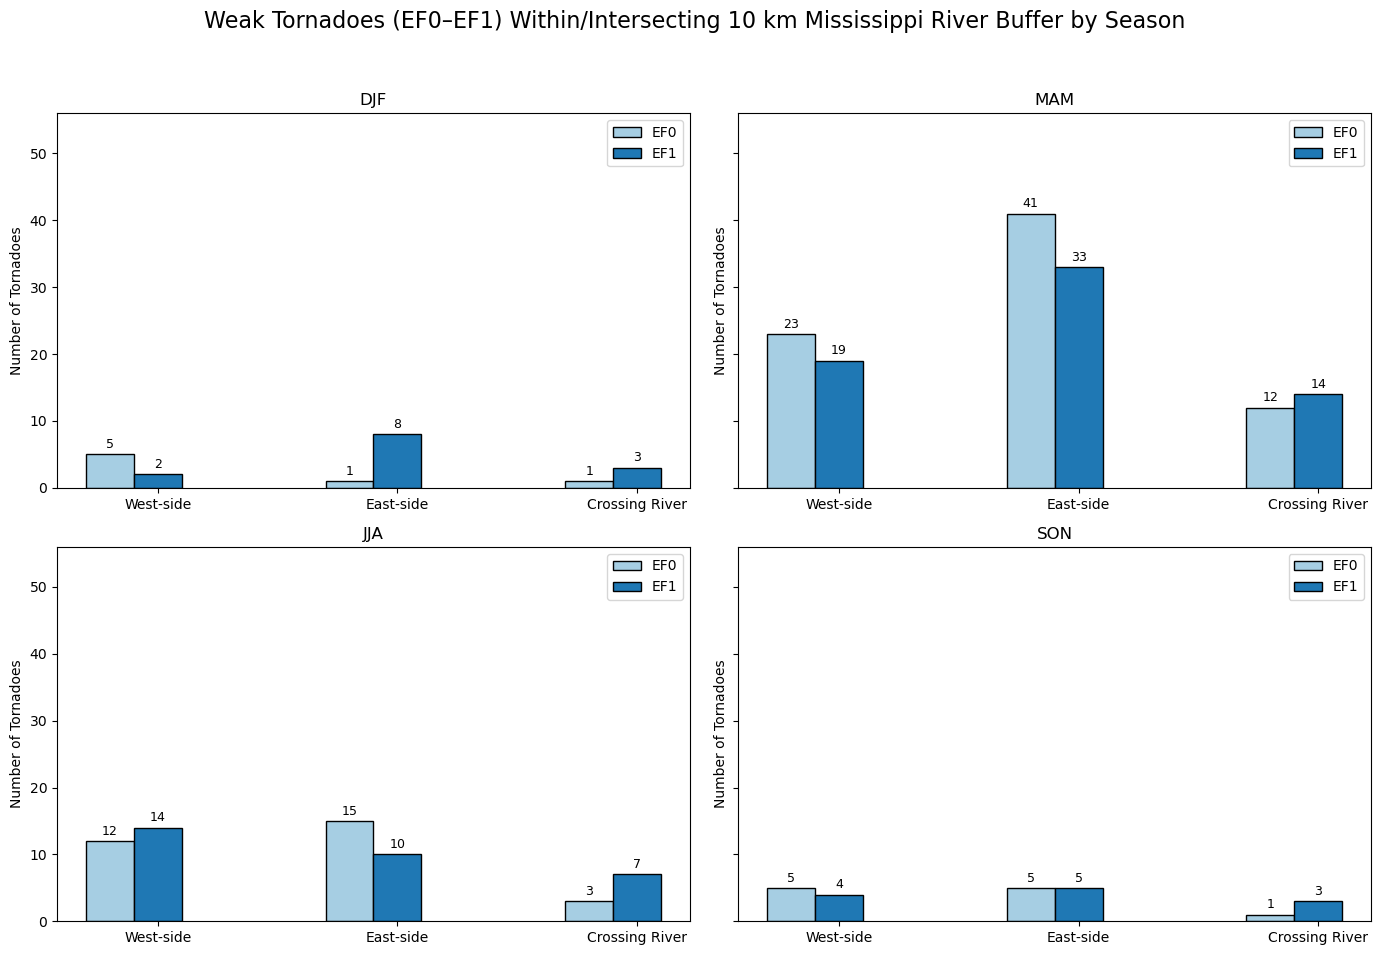

Totals by side_type across all seasons (should sum to 246):
side_type
East-side         118
West-side          84
Crossing River     44
Name: count, dtype: int64


In [44]:
# --- Ensure seasonal grouping ---
# Define a function to map month to meteorological season
def get_season(month):
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    else:
        return "SON"

# Filter to only river buffer tornadoes (246)
river_buffer_tornadoes = pd.concat([west_side, east_side, crossing_tornadoes])
river_buffer_tornadoes = river_buffer_tornadoes.copy()

# Assign side_type if not already
river_buffer_tornadoes.loc[river_buffer_tornadoes.index.isin(west_side.index), "side_type"] = "West-side"
river_buffer_tornadoes.loc[river_buffer_tornadoes.index.isin(east_side.index), "side_type"] = "East-side"
river_buffer_tornadoes.loc[river_buffer_tornadoes.index.isin(crossing_tornadoes.index), "side_type"] = "Crossing River"

# Assign season
river_buffer_tornadoes["season"] = river_buffer_tornadoes["date"].dt.month.apply(get_season)

# --- Prepare plotting data ---
plot_data = river_buffer_tornadoes.groupby(["season", "side_type", "mag"]).size().reset_index(name="count")

# Define order
seasons = ["DJF", "MAM", "JJA", "SON"]
sides = ["West-side", "East-side", "Crossing River"]
ef_order = [0, 1]
colors = {0: "#a6cee3", 1: "#1f78b4"}  # EF0, EF1

# --- 2x2 subplot setup ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    season_data = plot_data[plot_data["season"] == season]

    # Width and positions
    bar_width = 0.2
    x = np.arange(len(sides))

    # Plot EF0, EF1, EF2 stacked for each side
    for j, ef in enumerate(ef_order):
        ef_counts = []
        for side in sides:
            val = season_data[(season_data["side_type"] == side) & (season_data["mag"] == ef)]["count"]
            ef_counts.append(val.values[0] if not val.empty else 0)
        
        bottom = None
        if j == 0:
            bottom = np.zeros(len(sides))
        else:
            bottom = np.array([
                season_data[(season_data["side_type"] == side) & (season_data["mag"] < ef)]["count"].sum()
                for side in sides
            ])
        bars = ax.bar(x + j*bar_width, ef_counts, width=bar_width, color=colors[ef], label=f"EF{ef}", edgecolor='k')
        
        # Add counts above bars
        for rect, count in zip(bars, ef_counts):
            if count > 0:
                ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + rect.get_y() + 0.5,
                        int(count), ha='center', va='bottom', fontsize=9, color='black')

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(sides)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_ylabel("Number of Tornadoes")
    ax.set_ylim(0, max(plot_data["count"])+15)
    ax.legend()

plt.suptitle("Weak Tornadoes (EF0–EF1) Within/Intersecting 10 km Mississippi River Buffer by Season", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Print summed counts for verification ---
print("Totals by side_type across all seasons (should sum to 246):")
print(river_buffer_tornadoes["side_type"].value_counts())

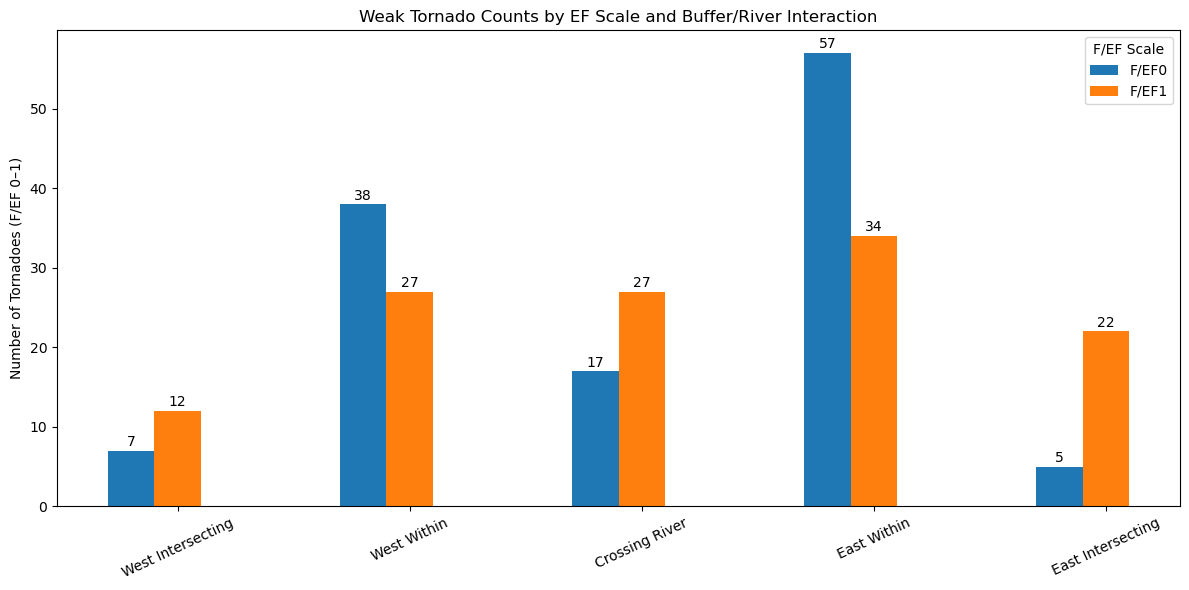

In [45]:
import matplotlib.pyplot as plt

# --- Step 1: Define helper to classify "completely within" vs "intersecting" ---
def completely_within(geom, buffer_geom):
    if geom.geom_type == "Point":
        return buffer_geom.contains(geom)
    elif geom.geom_type == "LineString":
        # Get boundary points as a list
        pts = list(geom.boundary.geoms)
        return buffer_geom.contains(pts[0]) and buffer_geom.contains(pts[1])
    return False

# --- Step 2: Separate the west and east tornadoes into intersecting vs completely within ---
west_intersecting = west_side[~west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

east_intersecting = east_side[~east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

# crossing already exists
crossing = crossing_tornadoes.copy()

# --- Step 3: Compute EF-scale counts for each bin ---
bins = {
    "West Intersecting": west_intersecting,
    "West Within": west_within,
    "Crossing River": crossing,
    "East Within": east_within,
    "East Intersecting": east_intersecting
}

ef_counts = {k: v['mag'].value_counts().reindex([0,1], fill_value=0) for k,v in bins.items()}

# Convert to DataFrame for plotting
ef_df = pd.DataFrame(ef_counts).T  # rows=bins, columns=EF scale
ef_df.index.name = 'Bin'
ef_df.columns = ['F/EF0', 'F/EF1']

# --- Step 4: Plot clustered bar chart ---
fig, ax = plt.subplots(figsize=(12,6))

bar_width = 0.2
x = np.arange(len(ef_df))  # 5 clusters

# Store bar containers for labeling
bars = []
for i, ef in enumerate(ef_df.columns):
    b = ax.bar(x + i*bar_width, ef_df[ef], width=bar_width, label=ef)
    bars.append(b)

# --- Add data labels on top of bars ---
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,  # center of the bar
            height + 0.2,                     # slightly above the bar
            f'{int(height)}',                 # convert to integer if counts
            ha='center', va='bottom', fontsize=10
        )

ax.set_xticks(x + bar_width)
ax.set_xticklabels(ef_df.index, rotation=25)
ax.set_ylabel("Number of Tornadoes (F/EF 0–1)")
ax.set_title("Weak Tornado Counts by EF Scale and Buffer/River Interaction")
ax.legend(title="F/EF Scale")
plt.tight_layout()
plt.show()

Total tornadoes in 5-box boxplot: 410


/tmp/ipykernel_841/1333937031.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




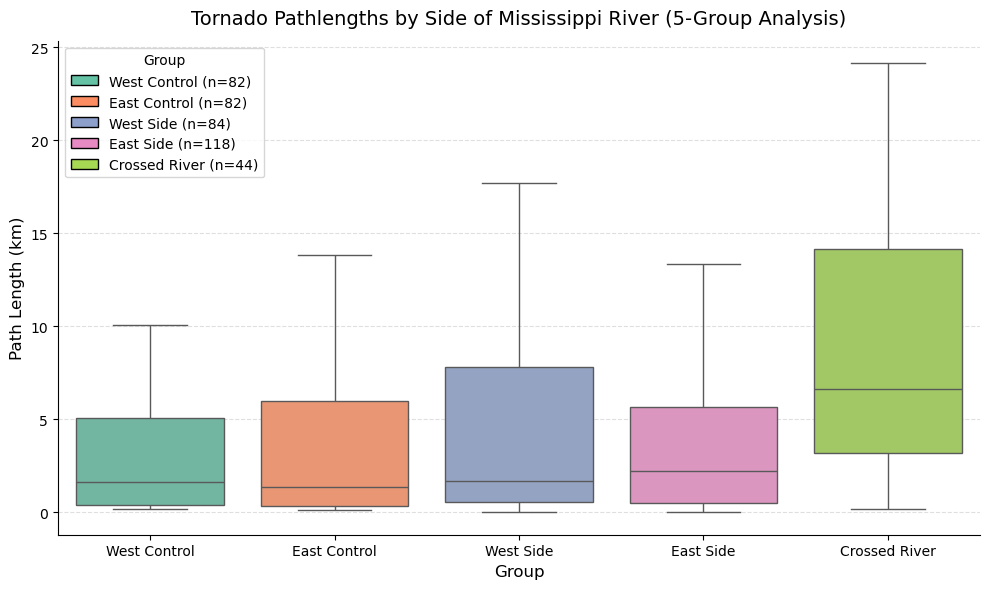


Five-number summary (km) for all 5 groups:
                    Min        Q1    Median         Q3         Max
side_type                                                         
Crossed River  0.160934  3.178446  6.614387  14.166215  237.216716
East Control   0.128747  0.321868  1.359892   5.978698   40.877236
East Side      0.032187  0.498895  2.212842   5.680970  122.148906
West Control   0.160934  0.406358  1.609340   5.057351   48.441134
West Side      0.000000  0.543152  1.681760   7.785182   44.900586


In [46]:
# ==========================================================
# --- Step 1: Prepare DataFrames for plotting ---
# ==========================================================

# --- Randomly sample West/East Control to n=82 ---
west_control_sampled = west_control.sample(n=82, replace=False, random_state=42)
east_control_sampled = east_control.sample(n=82, replace=False, random_state=42)

# West Control
west_control_plot = west_control_sampled[['len']].copy()
west_control_plot['side_type'] = "West Control"

# East Control
east_control_plot = east_control_sampled[['len']].copy()
east_control_plot['side_type'] = "East Control"

# West Side
west_side_plot = west_side[['len']].copy()
west_side_plot['side_type'] = "West Side"

# East Side
east_side_plot = east_side[['len']].copy()
east_side_plot['side_type'] = "East Side"

# Crossing River
cross_plot = crossing_tornadoes[['len']].copy()
cross_plot['side_type'] = "Crossed River"

# ==========================================================
# --- Step 2: Convert pathlength miles → kilometers ---
# ==========================================================

for df in [west_control_plot, east_control_plot, west_side_plot, east_side_plot, cross_plot]:
    df['len'] = df['len'] * 1.60934

# ==========================================================
# --- Step 3: Combine datasets ---
# ==========================================================

plot_df_full = pd.concat([
    west_control_plot,
    east_control_plot,
    west_side_plot,
    east_side_plot,
    cross_plot
], ignore_index=True)

print("Total tornadoes in 5-box boxplot:", len(plot_df_full))

# ==========================================================
# --- Step 4: Create boxplot ---
# ==========================================================

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", 5)

ax = sns.boxplot(
    data=plot_df_full,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False
)

# ==========================================================
# --- Step 5: Legend with actual sample sizes ---
# ==========================================================

counts_full = plot_df_full["side_type"].value_counts()

legend_elements = [
    Patch(
        facecolor=palette[i],
        edgecolor='black',
        label=f"{category} (n={counts_full[category]})"
    )
    for i, category in enumerate([
        "West Control",
        "East Control",
        "West Side",
        "East Side",
        "Crossed River"
    ])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# ==========================================================
# --- Step 6: Formatting ---
# ==========================================================

ax.set_title("Tornado Pathlengths by Side of Mississippi River (5-Group Analysis)", 
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# ==========================================================
# --- Step 7: Five-number summary ---
# ==========================================================

summary_stats_full = (
    plot_df_full.groupby("side_type")['len']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats_full.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary (km) for all 5 groups:")
print(summary_stats_full)


In [47]:
# ==========================================================
# --- Step 8: Kruskal–Wallis tests ---
# ==========================================================

groups_full = plot_df_full.groupby('side_type')['len'].apply(list)

# Extract lists for clarity
west_control_len = groups_full['West Control']
east_control_len = groups_full['East Control']
west_side_len = groups_full['West Side']
east_side_len = groups_full['East Side']
cross_len = groups_full['Crossed River']

# --- 1. Overall Kruskal-Wallis test ---
stat, p = kruskal(west_control_len, east_control_len,
                  west_side_len, east_side_len, cross_len)

print(f"\nOverall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# --- 2. Pairwise tests ---
pairs = list(itertools.combinations(groups_full.index, 2))
results = []

for a, b in pairs:
    stat_ab, p_ab = kruskal(groups_full[a], groups_full[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': stat_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

# Evaluated at the 0.05 significance level.


Overall Kruskal-Wallis test: H = 28.701, p = 0.0000

Pairwise Kruskal-Wallis results:
          Group1        Group2          H   p-value Significant?
0  Crossed River  East Control  22.628898  0.000002          Yes
1  Crossed River     East Side  23.276311  0.000001          Yes
2  Crossed River  West Control  22.613737  0.000002          Yes
3  Crossed River     West Side  14.532666  0.000138          Yes
4   East Control     East Side   0.556352  0.455734           No
5   East Control  West Control   0.136325  0.711962           No
6   East Control     West Side   0.871536  0.350530           No
7      East Side  West Control   0.338322  0.560799           No
8      East Side     West Side   0.043638  0.834528           No
9   West Control     West Side   0.329563  0.565916           No


### Kruskal–Wallis Test on Tornado Path Lengths (Five Groups)

**Overall Test:**
- **Kruskal–Wallis H = 28.701**, **p = 0.0000**
- **Interpretation:** At the 0.05 significance level, there **is a statistically significant overall difference** in tornado path lengths among the five groups (West Control, East Control, West Side, East Side, Crossed River).

---

**Pairwise Comparisons:**

| Group 1        | Group 2        | H         | p-value      | Significant? |
|----------------|----------------|-----------|--------------|--------------|
| Crossed River  | East Control   | 22.628898 | 0.000002     | Yes          |
| Crossed River  | East Side      | 23.276311 | 0.000001     | Yes          |
| Crossed River  | West Control   | 22.613737 | 0.000002     | Yes          |
| Crossed River  | West Side      | 14.532666 | 0.000138     | Yes          |
| East Control   | East Side      | 0.556352  | 0.455734     | No           |
| East Control   | West Control   | 0.136325  | 0.711962     | No           |
| East Control   | West Side      | 0.871536  | 0.350530     | No           |
| East Side      | West Control   | 0.338322  | 0.560799     | No           |
| East Side      | West Side      | 0.043638  | 0.834528     | No           |
| West Control   | West Side      | 0.329563  | 0.565916     | No           |

---

### Summary of Findings:
- The **Crossed River** group shows **significantly different** tornado path lengths compared to **all four** other groups.
- No significant differences were found among the other groups:
  - **West Control**, **East Control**, **West Side**, and **East Side** all have **statistically similar** path length distributions.
- These results suggest that tornadoes which **cross the Mississippi River** exhibit **distinctly different path length characteristics**, even when the control groups are size-matched through random subsampling.

Total tornadoes included: 410
side_type
East Side        118
West Side         84
West Control      82
East Control      82
Crossed River     44
Name: count, dtype: int64


/tmp/ipykernel_841/3858549480.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




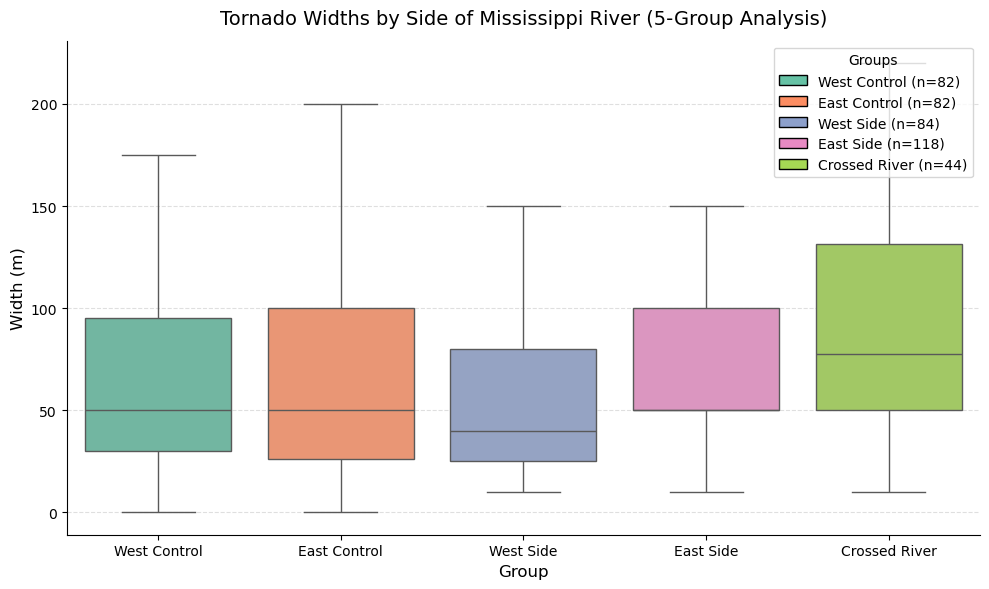


Five-number summary (m) for all 5 groups:
                Min     Q1  Median      Q3     Max
side_type                                         
Crossed River  10.0  50.00    77.5  131.25   800.0
East Control    0.0  26.25    50.0  100.00  1000.0
East Side      10.0  50.00    50.0  100.00   600.0
West Control    0.0  30.00    50.0   95.00  1320.0
West Side      10.0  25.00    40.0   80.00   880.0


In [50]:
# -------------------------------------------------------
# Step 1 — Prepare DataFrames (width in meters)
# -------------------------------------------------------

# West Control (random sample n = 82)
west_width = west_control[['wid']].copy()
west_width['side_type'] = "West Control"
west_width_sample = west_width.sample(n=82, random_state=42)

# East Control (random sample n = 82)
east_width = east_control[['wid']].copy()
east_width['side_type'] = "East Control"
east_width_sample = east_width.sample(n=82, random_state=42)

# West Side (n = 84)
west_side_width = west_side[['wid']].copy()
west_side_width['side_type'] = "West Side"

# East Side (n = 118)
east_side_width = east_side[['wid']].copy()
east_side_width['side_type'] = "East Side"

# Crossing River (n = 44)
cross_width = crossing_tornadoes[['wid']].copy()
cross_width['side_type'] = "Crossed River"

# -------------------------------------------------------
# Step 2 — Combine into a single plotting DataFrame
# -------------------------------------------------------
width_df = pd.concat([
    west_width_sample,
    east_width_sample,
    west_side_width,
    east_side_width,
    cross_width
], ignore_index=True)

print("Total tornadoes included:", len(width_df))
print(width_df['side_type'].value_counts())

# -------------------------------------------------------
# Step 3 — Create Box Plot for Width (m)
# -------------------------------------------------------

plt.figure(figsize=(10, 6))

# Define consistent ordering for groups
category_order = [
    "West Control",
    "East Control",
    "West Side",
    "East Side",
    "Crossed River"
]

palette = sns.color_palette("Set2", len(category_order))

ax = sns.boxplot(
    data=width_df,
    x="side_type",
    y="wid",
    order=category_order,        # <--- enforce ordering
    palette=palette,
    showfliers=False
)

# Legend with correct colors
counts = width_df["side_type"].value_counts()

legend_elements = [
    Patch(
        facecolor=palette[i],
        edgecolor='black',
        label=f"{category} (n={counts[category]})"
    )
    for i, category in enumerate(category_order)
]

ax.legend(
    handles=legend_elements,
    loc='upper right',
    fontsize=10,
    title="Groups",
    frameon=True
)

ax.set_title("Tornado Widths by Side of Mississippi River (5-Group Analysis)",
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()
# ==========================================================
# --- Step 4: Five-number summary ---
# ==========================================================

summary_stats_full = (
    width_df.groupby("side_type")['wid']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats_full.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary (m) for all 5 groups:")
print(summary_stats_full)

In [49]:
# -------------------------------------------------------
# Step 5 — Kruskal–Wallis Test (All Five Groups)
# -------------------------------------------------------
groups = width_df.groupby('side_type')['wid'].apply(list)

# Extract lists for KW
group_lists = [groups[g] for g in groups.index]

stat, p = kruskal(*group_lists)

print(f"\nOverall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# -------------------------------------------------------
# Step 6 — Pairwise Kruskal–Wallis Tests
# -------------------------------------------------------
pairs = list(itertools.combinations(groups.index, 2))
results = []

for a, b in pairs:
    h_ab, p_ab = kruskal(groups[a], groups[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': h_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

# Evaluated at the 0.05 significance level.


Overall Kruskal-Wallis test: H = 16.314, p = 0.0026

Pairwise Kruskal-Wallis results:
          Group1        Group2          H   p-value Significant?
0  Crossed River  East Control   5.814720  0.015893          Yes
1  Crossed River     East Side   3.182363  0.074437           No
2  Crossed River  West Control   6.302701  0.012055          Yes
3  Crossed River     West Side  11.472496  0.000706          Yes
4   East Control     East Side   2.530645  0.111655           No
5   East Control  West Control   0.280637  0.596284           No
6   East Control     West Side   0.430805  0.511594           No
7      East Side  West Control   2.034618  0.153753           No
8      East Side     West Side   8.883263  0.002878          Yes
9   West Control     West Side   2.443938  0.117980           No


### Kruskal–Wallis Test on Tornado Widths (Five Groups)

**Overall Test:**
- **Kruskal–Wallis H = 16.314**, **p = 0.0026**
- **Interpretation:** At the 0.05 significance level, there **is a statistically significant overall difference** in tornado widths among the five groups.

**Pairwise Comparisons:**

| Group 1       | Group 2       | H        | p-value     | Significant? |
|---------------|---------------|----------|-------------|--------------|
| Crossed River | East Control  | 5.8147   | 0.015893    | Yes          |
| Crossed River | East Side     | 3.1824   | 0.074437    | No           |
| Crossed River | West Control  | 6.3027   | 0.012055    | Yes          |
| Crossed River | West Side     | 11.4725  | 0.000706    | Yes          |
| East Control  | East Side     | 2.5306   | 0.111655    | No           |
| East Control  | West Control  | 0.2806   | 0.596284    | No           |
| East Control  | West Side     | 0.4308   | 0.511594    | No           |
| East Side     | West Control  | 2.0346   | 0.153753    | No           |
| East Side     | West Side     | 8.8833   | 0.002878    | Yes          |
| West Control  | West Side     | 2.4439   | 0.117980    | No           |

**Summary:**
- **Crossed River tornadoes** are significantly wider than:
  - **East Control**
  - **West Control**
  - **West Side**
- **East Side vs. West Side** also shows a significant difference.
- No significant differences appear between:
  - East vs. West Control  
  - East vs. West Side  
  - East Side vs. West Control  

**Conclusion:**  
Tornado widths show **meaningful spatial variation**, with the **Crossed River** group driving most of the significant differences. The strongest contrast occurs between **Crossed River vs. West Side**, and between **East Side vs. West Side**, suggesting localized influences near and across the river corridor.

In [50]:
# --- Step 0: Ensure tornado_gdf is loaded and river_il_geom exists ---
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_gdf = tornado_gdf.to_crs(target_crs)
river_gs = gpd.GeoSeries([river_il_geom], crs=target_crs)
river_il_geom = river_gs.iloc[0]

# --- Helper functions ---
def start_point(geom):
    return Point(geom.coords[0]) if geom.geom_type == 'LineString' else geom

def end_point(geom):
    return Point(geom.coords[-1]) if geom.geom_type == 'LineString' else geom

def get_season(month):
    if month in [12,1,2]: return 'DJF'
    if month in [3,4,5]: return 'MAM'
    if month in [6,7,8]: return 'JJA'
    return 'SON'

# Distance with sign relative to river centerline
def signed_distance_km(point, river_geom):
    nearest_pt = nearest_points(point, river_geom)[1]
    dist = point.distance(nearest_pt) / 1000  # meters -> km
    # Assign negative if west of river centroid
    return -dist if point.x < river_geom.centroid.x else dist

# --- Step 1: Start/end points and season ---
tornado_gdf['start_pt'] = tornado_gdf['geometry'].apply(start_point)
tornado_gdf['end_pt'] = tornado_gdf['geometry'].apply(end_point)
tornado_gdf['season'] = tornado_gdf['date'].dt.month.apply(get_season)

In [51]:
# --- Step 2: Classify tornadoes ---
river_buffer = river_il_geom.buffer(10000)  # 10 km buffer
river_center_x = river_il_geom.centroid.x

def classify_side(row):
    if row['geometry'].intersects(river_il_geom):
        return 'Crossed River'
    centroid_x = row['geometry'].centroid.x
    if centroid_x < river_center_x and row['geometry'].intersects(river_buffer):
        return 'West-side'
    elif centroid_x >= river_center_x and row['geometry'].intersects(river_buffer):
        return 'East-side'
    return None

tornado_gdf['side_type'] = tornado_gdf.apply(classify_side, axis=1)

# --- Step 3: Compute signed distances ---
tornado_gdf['start_dist_km'] = tornado_gdf['start_pt'].apply(lambda p: signed_distance_km(p, river_il_geom))
tornado_gdf['end_dist_km'] = tornado_gdf['end_pt'].apply(lambda p: signed_distance_km(p, river_il_geom))

In [52]:
# --- Step 4: Build summary table ---
rows = ['Start West', 'Start Crossed', 'Start East', 'End West', 'End Crossed', 'End East']
cols = ['DJF','MAM','JJA','SON','Annual']

table = pd.DataFrame(index=rows, columns=cols)

for season in ['DJF','MAM','JJA','SON']:
    seasonal = tornado_gdf[tornado_gdf['season']==season]
    
    for side, row_prefix in zip(['West-side','Crossed River','East-side'],
                                ['West','Crossed','East']):
        # Start
        values = seasonal[seasonal['side_type']==side]['start_dist_km']
        table.loc[f'Start {row_prefix}', season] = round(values.mean(),2) if not values.empty else '--'
        # End
        values = seasonal[seasonal['side_type']==side]['end_dist_km']
        table.loc[f'End {row_prefix}', season] = round(values.mean(),2) if not values.empty else '--'

# Annual averages
for side, row_prefix in zip(['West-side','Crossed River','East-side'],
                            ['West','Crossed','East']):
    values = tornado_gdf[tornado_gdf['side_type']==side]['start_dist_km']
    table.loc[f'Start {row_prefix}','Annual'] = round(values.mean(),2) if not values.empty else '--'
    values = tornado_gdf[tornado_gdf['side_type']==side]['end_dist_km']
    table.loc[f'End {row_prefix}','Annual'] = round(values.mean(),2) if not values.empty else '--'

# Display
display(table)

,DJF,MAM,JJA,SON,Annual
Start West,-5.97,-6.64,-4.05,-6.02,-5.72
Start Crossed,0.83,-2.5,1.16,0.81,-1.06
Start East,6.37,4.7,5.17,4.94,4.94
End West,-4.44,-5.39,-3.24,-5.81,-4.69
End Crossed,30.77,-0.22,4.32,3.61,3.98
End East,7.29,7.33,5.62,5.73,6.83


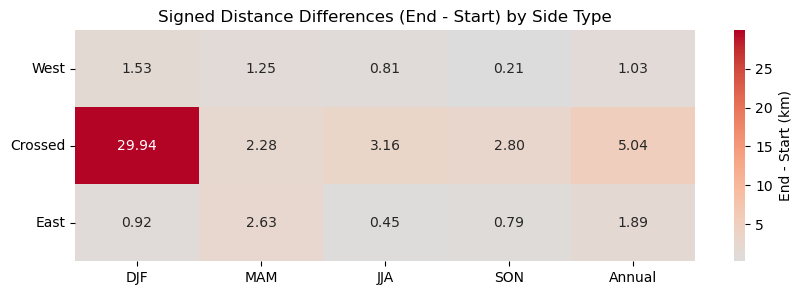

In [53]:
# --- Step 5: Compute differences (End - Start) per side type ---
diff_table = pd.DataFrame(index=['West','Crossed','East'], columns=cols)

for side_prefix in ['West','Crossed','East']:
    for col in cols:
        start_val = table.loc[f'Start {side_prefix}', col]
        end_val = table.loc[f'End {side_prefix}', col]
        if start_val == '--' or end_val == '--':
            diff_table.loc[side_prefix, col] = None
        else:
            diff_table.loc[side_prefix, col] = round(end_val - start_val, 2)

# --- Step 6: Display heatmap of differences ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.heatmap(diff_table.astype(float), annot=True, fmt=".2f",
            cmap="coolwarm", center=0, cbar_kws={'label': 'End - Start (km)'})
plt.title("Signed Distance Differences (End - Start) by Side Type")
plt.yticks(rotation=0)
plt.show()

In [54]:
# --- Count tornadoes by side type ---
counts = tornado_gdf['side_type'].value_counts()

print("Number of tornadoes per side type:")
print(f"West Side: {counts.get('West-side', 0)}")
print(f"Crossed River: {counts.get('Crossed River', 0)}")
print(f"East Side: {counts.get('East-side', 0)}")
print(f"Total tornadoes in table: {counts.sum()}")

Number of tornadoes per side type:
West Side: 84
Crossed River: 44
East Side: 118
Total tornadoes in table: 246


In [ ]:
###############################
##Additional Work for Seasons##
###############################

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# --- Step 0: Make sure seasonal column exists ---
tornado_gdf['month'] = tornado_gdf['date'].dt.month
def get_season(month):
    if month in [12, 1, 2]: return 'DJF'
    elif month in [3, 4, 5]: return 'MAM'
    elif month in [6, 7, 8]: return 'JJA'
    else: return 'SON'
tornado_gdf['season'] = tornado_gdf['month'].apply(get_season)

# --- Step 1: Define helper functions ---
def completely_within(geom, buffer_geom):
    """Returns True if both endpoints of a LineString are within buffer_geom, or if a Point is within."""
    from shapely.geometry import Point, LineString, MultiPoint

    if geom.geom_type == 'Point':
        return buffer_geom.contains(geom)
    elif geom.geom_type == 'LineString':
        # Extract boundary points safely
        b = geom.boundary
        if isinstance(b, Point):
            pts = [b]
        elif isinstance(b, MultiPoint):
            pts = list(b.geoms)
        else:
            pts = list(b)  # fallback
        return all(buffer_geom.contains(pt) for pt in pts)
    return False

# Step 2: Pre-compute bins for all tornadoes (so seasonal plots match all-season bins)
west_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x < river_il_geom.centroid.x))]
east_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x > river_il_geom.centroid.x))]
crossing = tornado_gdf[tornado_gdf['crosses_river']==True]

# Compute intersecting vs within for west and east
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_intersecting = west_side[~west_side.index.isin(west_within.index)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_intersecting = east_side[~east_side.index.isin(east_within.index)]

# --- Step 3: Prepare seasonal counts per bin per EF-scale ---
bins_dict = {
    'West Intersecting': west_intersecting,
    'West Within': west_within,
    'Crossing': crossing,
    'East Within': east_within,
    'East Intersecting': east_intersecting
}

seasons = ['DJF', 'MAM', 'JJA', 'SON']
ef_scales = [0, 1, 2]

# --- Step 4: Plot ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    counts = []
    for bin_name, gdf_bin in bins_dict.items():
        season_bin = gdf_bin[gdf_bin['season']==season]
        ef_counts = [season_bin[season_bin['mag']==ef].shape[0] for ef in ef_scales]
        counts.append(ef_counts)
    
    counts_df = pd.DataFrame(counts, index=bins_dict.keys(), columns=[f'EF{ef}' for ef in ef_scales])
    counts_df.plot(kind='bar', stacked=False, ax=ax, width=0.8)
    
    ax.set_title(f"Weak Tornadoes by Bin and EF-scale ({season})", fontsize=12)
    ax.set_ylabel("Number of Tornadoes")
    ax.set_xlabel("Bin")
    ax.legend(title="EF-scale")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()